In [1]:
!pip install scikit-bio
!pip install skbio
!pip install georasters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import random
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import georasters as gr

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 99.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.3-cp311-cp311-linux_x86_64.whl size=7294506 sha256=8a1e25d31059f32975038d77585f9f1fddc5f37c0480e334e2ea33045e822469
  Stored in directory: /root/.cache/pip/wheels/c9/11/a2/86492071506a487bcba7015b710a9e89d66ca69845512fb86c
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12182960 sha256=86c662dd205c1d854e46563a47868be6daa778d543bc70d59b5396fc6cc673b5
  Stored in directory: /root/.cache/pip/wheels/a5/6b/58/a879e8fbae2479a3d1a68719f3a062fe62701d6494f1b74f5e
Successf

In [2]:
# variables

e_cut = 1e-16
col = 'group_id'
corr_f = stats.spearmanr
palett = sns.color_palette("Paired",11)
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'
label_hits_n = 'Num. plastic\ndegrading enzymes'
label_plast_n = 'Num. degradable\nplastic types'

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
plastic_order=['PET','PHB','PLA','PBAT',
                'PU','PS','PVA','PE',
                'PBS','PHA','Nylon','PEG','PHO',
                'TP','phthalate','DBP','PA']

env_old = ['Savannas',
 'Dry_tropical_forests',
 'Moist_tropical_forests',
 'Tropical_montane_forests',
 'Mediterrean',
 'Grasslands_and_shrublands',
 'Southern_temperate_forests',
 'Temperate_coniferous_forests',
 'Temperate_deciduous_forests',
 'Boreal_forests',
 'Arctic_tundra']

env_order = ['Savannas ',
 'Dry tropical forests',
 'Moist tropical forests',
 'Tropical montane forests',
 'Mediterranean ',
 'Grasslands and shrublands',
 'Southern temperate forests',
 'Temperate coniferous forests',
 'Temperate deciduous forests',
 'Boreal forests',
 'Arctic tundra']

dic_env = {env_old[i]: env_order[i] for i in range(len(env_order))}

dic_env2 = {'latitude': 'Latitude [°]',
 'longitude': 'Longitude [°]',
 'moisture': 'Moisture content [%]',
 'prec': 'Precipitation [L/m2]',
 'npp': 'NPP [g_C m−2 yr−1]',
 'pevapotrans': 'P. evapotrans. [L/m2]'}
dic_env2['conc_box_zscore'] = 'Exp. measured pollution'
dic_env2['num_hits'] = 'Num. hits'
dic_env2['pl_richness'] = 'Num. plastics'
dic_env2['carbon'] = 'Carbon [kg/m2]'
dic_env2['tmean'] = 'Temperature [°C]'

In [3]:
# functions

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load data

In [4]:
# soil metadata
df_soil_env = pd.read_csv('df_soil_env.csv')
# merge soil_params
df_soil_env = df_soil_env.merge(pd.read_csv('Soil_params.csv')
                                .rename(columns={'Unnamed: 0':'inscd_id'}),
                                on='inscd_id',how='left')
print(df_soil_env.shape)

# ena cross-mapping file
ena = pd.read_csv('filereport_read_run_PRJEB18701_tsv.txt',sep='\t')
ena['filename'] = ena.submitted_ftp.apply(lambda x: x.split('/')[-1].split('.')[0])
print(ena.filename.unique().shape)
print(ena.sample_alias.unique().shape)

# fix filenames - remove 'R2_' and '_2 from Nrs and '_001' if 'old_'
ena['filename'] = [x[:-2] if 'Nr' in x else x.replace('R2_','')[:-4] if 'old_' in x else x.replace('R2_','') for x in ena.filename]

(340, 26)
(288,)
(189,)


In [5]:
# load results (modified from original code to fix value error)

# load results
fdata = ['soil_bork_parsed.csv',
         'soil_australia_parsed.csv',
         'soil_china_parsed.csv']
tmp = []
for f in fdata:
    tmp.append(pd.read_csv(f))
dfs = pd.concat(tmp)
print(dfs.shape)

# sanity check merging on filenames
print(dfs[dfs.dataset=='soil_bork']
      .target_name
      .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x
             else '_'.join(x.split('_')[:5]))
      .unique()
      .shape
     )
print(all(pd.Series(dfs[dfs.dataset=='soil_bork']
                    .target_name
                    .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x
                           else '_'.join(x.split('_')[:5]))
                    .unique().tolist()
                   ).isin(ena.filename.unique().tolist())
         ))

# Fix: Use .loc instead of .at
dfs.loc[dfs.dataset=='soil_bork', 'filename'] = (dfs[dfs.dataset=='soil_bork']
                                                 .target_name
                                                 .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x
                                                        else '_'.join(x.split('_')[:5]))
                                                )

# store
dfs['id_other'] = dfs.id
dfs.drop(columns=['id'], inplace=True)

# merge bork data
dfs = (dfs.merge(ena[['filename', 'run_accession']]
                 .rename(columns={'run_accession': 'run'}),
                on='filename', how='left')
      )
print(dfs.shape)

# Fix: Use .loc instead of .at
dfs.loc[dfs.dataset=='soil_australia', 'run'] = (dfs[dfs.dataset=='soil_australia']
                                                 .target_name
                                                 .apply(lambda x: x.split('_')[0])
                                                )
dfs.loc[dfs.dataset=='soil_china', 'run'] = (dfs[dfs.dataset=='soil_china']
                                             .target_name
                                             .apply(lambda x: x.split('_')[0])
                                            )

# merge
dfs = dfs.merge(df_soil_env[['run', 'latitude', 'longitude', 'country', 'environment']],
                on='run', how='left')
print(dfs.shape)

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives), 'additive'] = True
dfs['group_id'] = dfs.run

# cleanup
dfs = (dfs
       .drop(columns=['target_id', 'label', 'filename'])
       .rename(columns={
           # 'lats': 'latitude',
           # 'lons': 'longitude',
           'e-value': 'e_value'})
      )
print(dfs.shape)

# rename some countries
dic = {'Viet Nam': 'Vietnam',
       'Democratic Republic of the Congo': 'Democratic Republic of Congo',
       'USA': 'United States'}
dfa = dfs.replace({'country': dic})

(18279, 22)
(262,)
True
(18279, 24)
(18279, 28)
(18279, 27)


# Analysis

AttributeError: 'GrouperView' object has no attribute 'join'

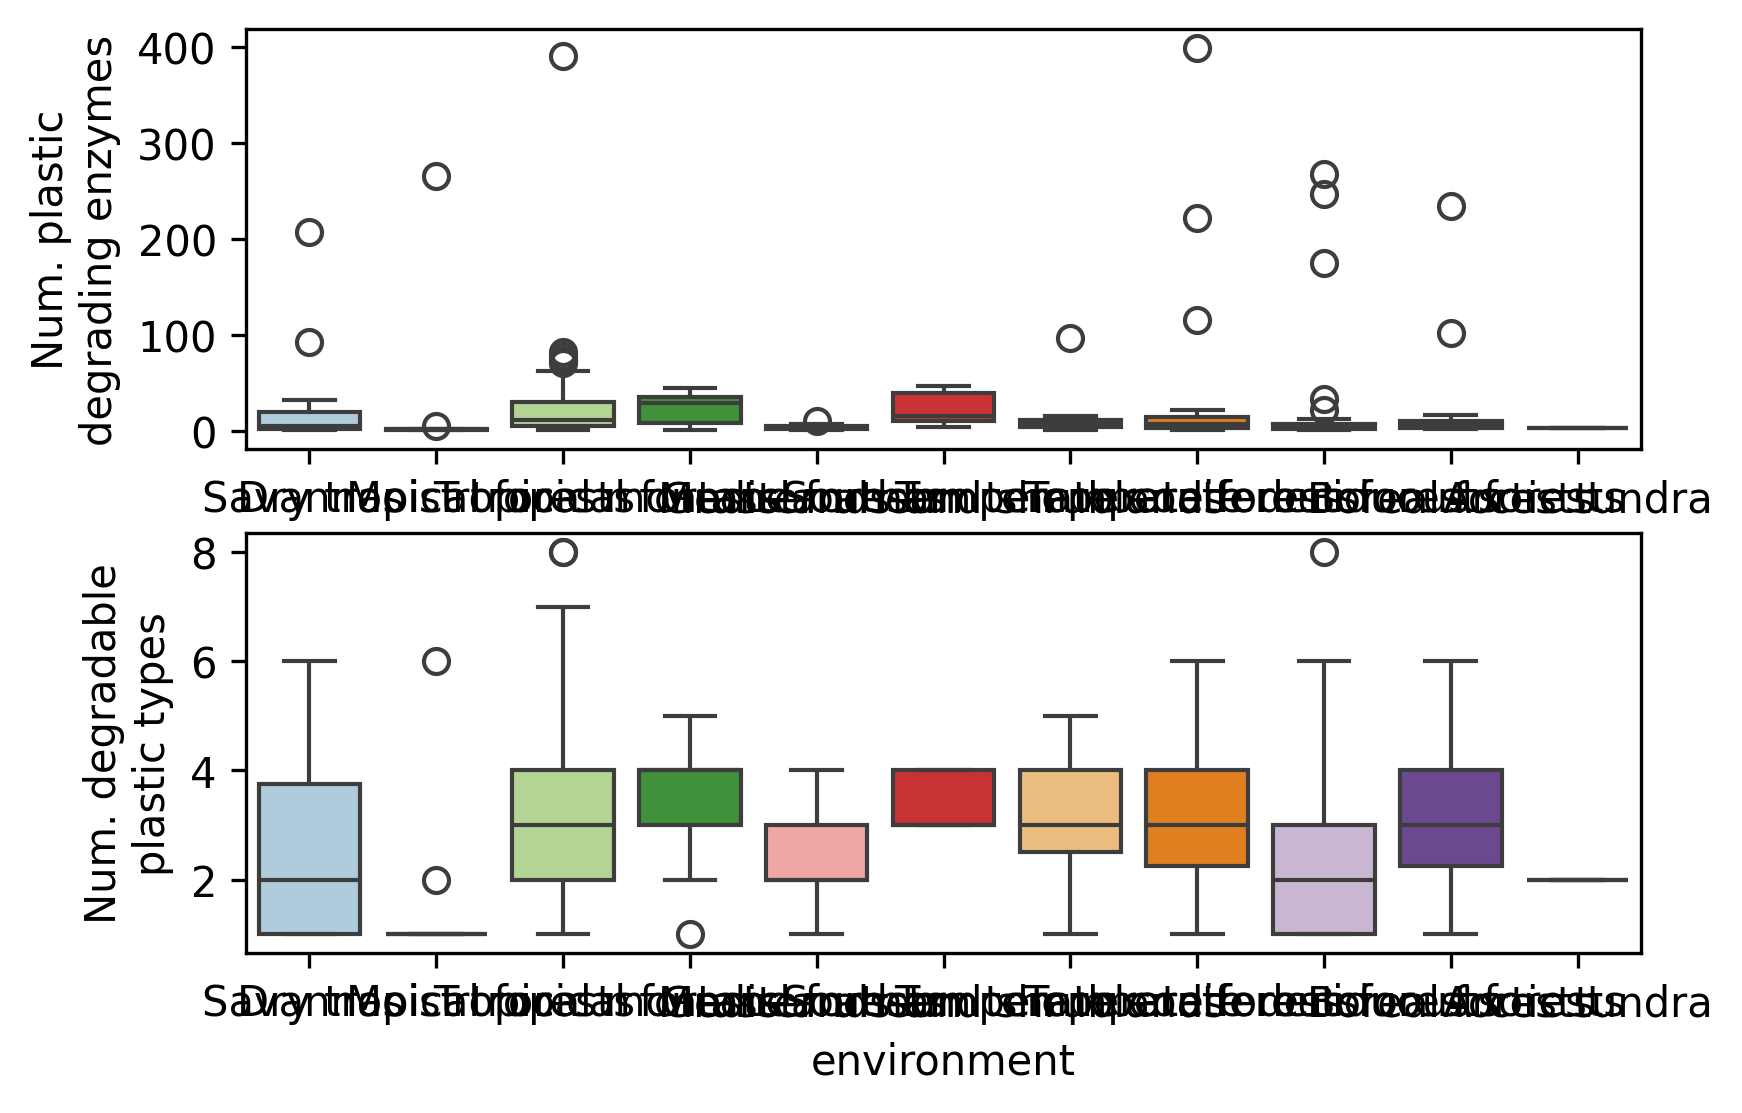

In [6]:
# per soil habitat - separate plots
# average per sampling site and variability
# make long df and use facet grid
col2 = 'environment'
dfs = (dfa
       .query('e_value<=@e_cut')
       .query("dataset=='soil_bork'")
        .replace({'environment':dic_env})
      )

tmp = []
tmp.append(dfs.groupby([col2,col]).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs.groupby([col2,col]).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs.groupby([col2,col]).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# via subplots
mpl.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(2,figsize=(6,4))

k=0
for what in ['Num. hits','Num. plast.']:
    sns.boxplot(data=pd.concat(tmp).query('ylabel==@what'),
            x=col2,y='value',
                order=env_order,
                ax=axs[k],
                palette=palett
               )
    if what == 'Num. hits':
        axs[k].set_ylabel(label_hits_n)
    else:
        axs[k].set_ylabel(label_plast_n)
    k+=1

axs[-1].get_shared_x_axes().join(*axs)
[axs[k].set_xticklabels([]) for k in range(1)]
[axs[k].set_xlabel('') for k in range(1)]
plt.xticks(rotation=45,ha='right')
plt.xlabel('')
axs[0].set_yscale('log')
axs[0].set_ylim([0.7,1000])
axs[0].set_yticks([1,10,100,1000])
#axs[0].set_title('Soil')
plt.show()

In [7]:
dfs.groupby('environment').group_id.nunique()

,group_id
environment,
Arctic tundra,1
Boreal forests,14
Dry tropical forests,9
Grasslands and shrublands,5
Mediterranean,13
Moist tropical forests,88
Savannas,14
Southern temperate forests,23
Temperate coniferous forests,18


In [8]:
# all vs the rest significance test
test = stats.ranksums
what = 'Num. hits'
data = pd.concat(tmp).query('ylabel==@what')
data

ranksum = []
for var in data.environment.unique():
    r,p = test(data.query('environment==@var').value,
         data.query('environment!=@var').value
        )
    n = data.query('environment==@var').shape[0]
    ranksum.append([var,p,n])
pd.DataFrame(ranksum,columns=['environment','p','n'])

,environment,p,n
0,Arctic tundra,0.381038,1
1,Boreal forests,0.941975,14
2,Dry tropical forests,0.003540,9
3,Grasslands and shrublands,0.159803,5
4,Mediterranean,0.001758,13
5,Moist tropical forests,0.004733,88
6,Savannas,0.503083,14
7,Southern temperate forests,0.775705,23
8,Temperate coniferous forests,0.947110,18
9,Temperate deciduous forests,0.000463,42


In [9]:
# stats for text
print(dfa.query('e_value<=@e_cut')
      .drop_duplicates(subset=['latitude','longitude'])
      .groupby('dataset').target_name.count())
print(dfs.country.nunique())
print(dfs.environment.nunique())

dataset
soil_australia      5
soil_bork         163
soil_china          1
Name: target_name, dtype: int64
38
11


# Correlation analysis

In [10]:
df_rich = (dfs
   .groupby(col)
    .target_name.count()
    .rename('num_hits')
    .reset_index()
)
df_rich['pl_richness'] = (dfs
   .groupby(col)
   .plastic.nunique()
   .values
)
df_rich['hmm_richness'] = (dfs
   .groupby(col)
   .hmm_model.nunique()
   .values
)
# concat
df_rich = df_rich.merge(dfs[[col,'country']].drop_duplicates(),
                        on=col,how='left')
df_rich.head()

,group_id,num_hits,pl_richness,hmm_richness,country
0,ERR1877650,3,2,3,Mexico
1,ERR1877651,10,3,9,Sri Lanka
2,ERR1877652,3,2,2,Finland
3,ERR1877653,13,3,8,Russia
4,ERR1877654,4,3,4,Colombia


### Environmental variables

In [11]:
# merge
data = (df_rich
 .merge(df_soil_env
        ,on=col,how='left')
)
df_soil_env.columns

# correlatons
x = ['num_hits','pl_richness']
y = ['carbon','environment','latitude','longitude',
     'moisture','npp','pevapotrans','ph',
     'prec','tmax','tmin','tmean',
    'pH', 'Ca', 'Mg', 'P', 'K', 'C', 'N']

df_pcc = []
for colx in x:
    for coly in y:
        tmp1 = data[[colx,coly]].dropna()
        tmp2 = corr_f(tmp1[colx],tmp1[coly])
        df_pcc.append([colx,coly,tmp2[0],tmp2[1],tmp1.shape[0]])

df_pcc = (pd
          .DataFrame(df_pcc,columns=['x','y','r','p','n'])
          .query('p<1e-4')
          .query('x.isin(["num_hits","pl_richness"])')
          .sort_values(by='r',ascending=False)
         )
df_pcc

,x,y,r,p,n
5,num_hits,npp,0.417015,1.394718e-10,218
3,num_hits,longitude,0.331893,3.959860e-08,261
8,num_hits,prec,0.330465,4.562058e-08,261
24,pl_richness,npp,0.306956,3.873127e-06,218
4,num_hits,moisture,0.292393,6.820866e-06,229
6,num_hits,pevapotrans,0.258215,7.706040e-05,229
22,pl_richness,longitude,0.248481,4.930342e-05,261


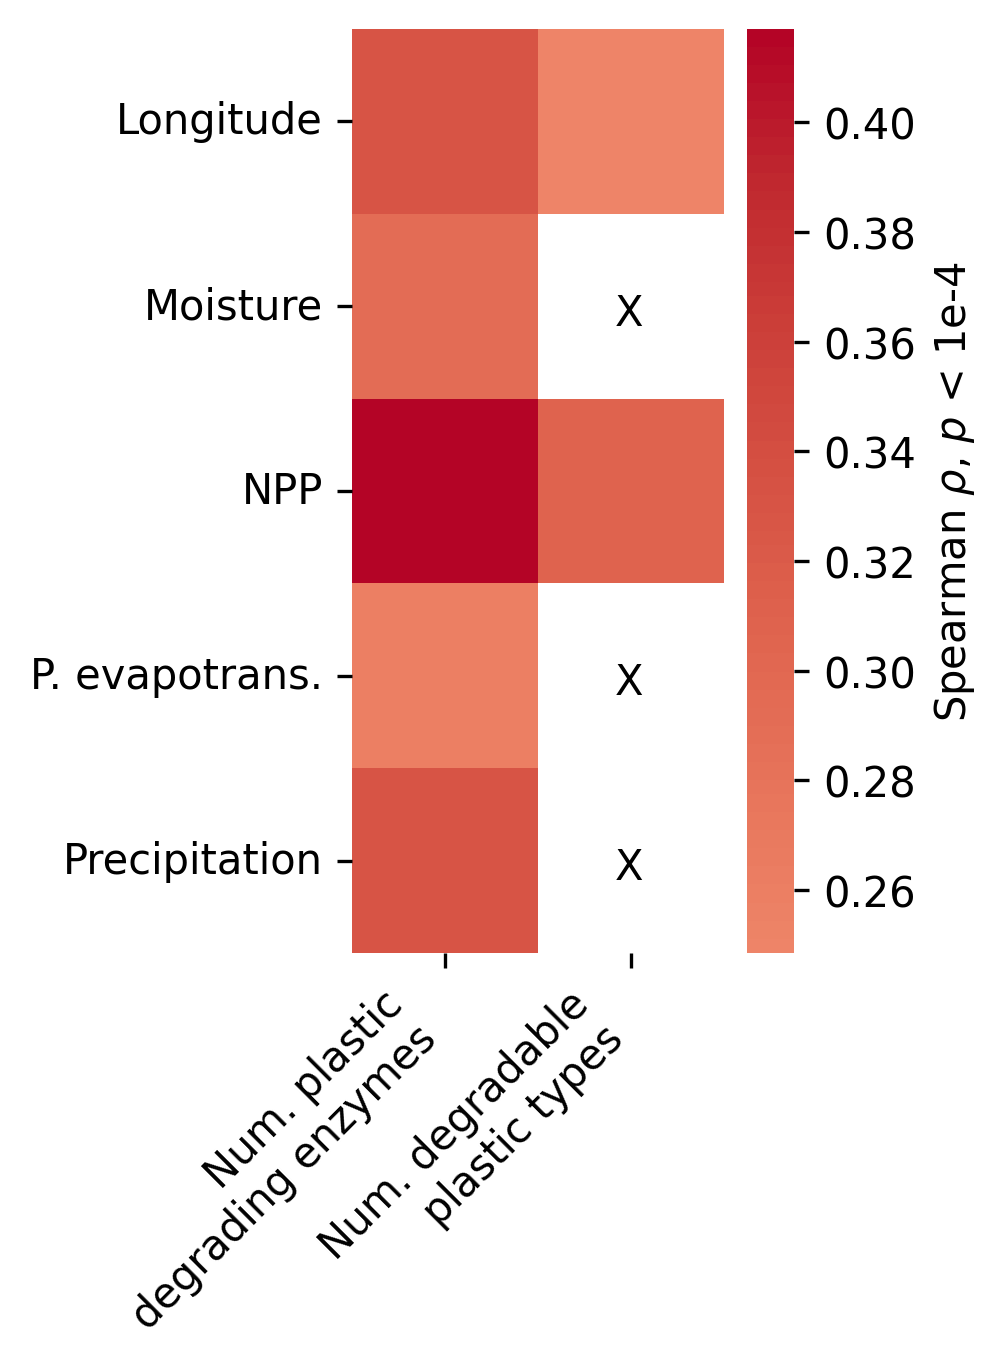

In [12]:
# plot this heatmap
dic_tmp = {'Npp':'NPP',
         'Pevapotrans':'P. evapotrans.',
         'Prec':'Precipitation'}
dic_x = {'num_hits':label_hits_n,
         'pl_richness':label_plast_n
        }

# get data to df
df_pcc['y']=df_pcc.y.str.capitalize()
data = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .replace({'y':dic_tmp})
        .pivot(index='x',columns='y',values='r')
        .transpose()
       )
data

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,4))
sns.heatmap(data[[label_hits_n,label_plast_n]],
            cmap='coolwarm',center=0,
           cbar_kws={'label': "Spearman "+r'$\rho$, $p$ < 1e-4',
                    })
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0,ha='right')
#plt.title('Soil, $p$ < 1e-4')

# plot xs for variables that are not below p-val cutoff
plt.annotate('X',xy=(1.41,1.6))
plt.annotate('X',xy=(1.41,3.6))
plt.annotate('X',xy=(1.41,4.6))

plt.show()

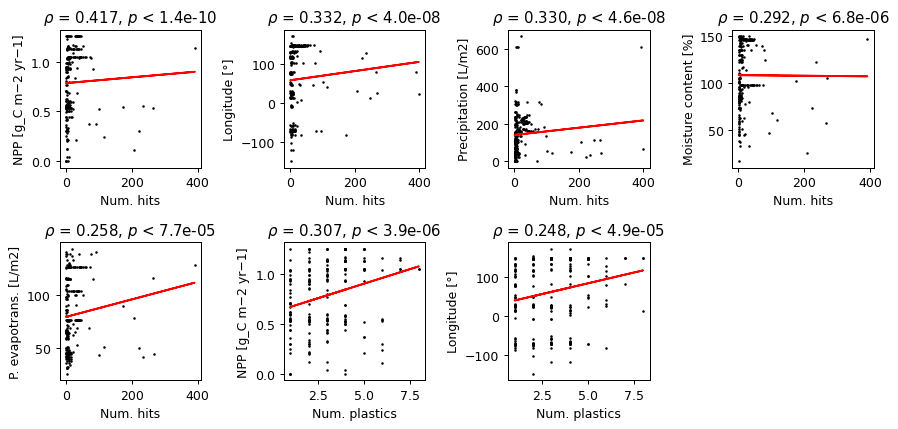

In [13]:
# Plot all correlations subplot
dic_x = {'num_hits': 'Num. hits',
         'pl_richness': 'Num. plastics'
        }

data = (df_rich
 .merge(df_soil_env
        ,on=col,how='left')
)
df_pcc['y']=df_pcc.y.str.lower()
tmp = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .sort_values(by='x')
)
tmp

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,6.8))
k=1
for idx,row in tmp.iterrows():

    plt.subplot(3,4,k)
    var1 = df_pcc.loc[idx].x
    var2 = df_pcc.loc[idx].y
    x = data[[var1,var2]].dropna()[var1]
    y = data[[var1,var2]].dropna()[var2]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, slope*x+intercept, 'r', label='fitted line')
    plt.xlabel(row.x)
    plt.ylabel(dic_env2[var2])
    plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
              ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
    k+=1

plt.tight_layout()
plt.show()

## Pollution data

In [14]:
def get_pcc(itr,corr_f=corr_f,col=col):
    d = itr[2]
    tmp = (itr[-1][itr[-1].dataset.isin(itr[3])]
           .query('dist<=@d')
          )

    r,p = corr_f(tmp[itr[0]],tmp[itr[1]])
    return itr[0],itr[1],itr[2],len(itr[3]),r,p,tmp[col].unique().shape[0],itr[3]

# load
pol_soil = pd.read_csv('inadequately-managed-plastic.csv',
                       names=['country','code','year','conc'],skiprows=1)
pol_soil['measure'] = pd.read_csv('inadequately-managed-plastic.csv',
                                  names=['country','code','year','conc']).conc.iloc[0]
pol_soil['dataset'] = 'inadequately-managed-plastic'
a,_ = stats.boxcox([x+1 for x in normalize(pol_soil.conc.values)])
pol_soil['conc_box_zscore'] = a
print(pol_soil.year.unique())
print(pol_soil.country.count())

# correlations
data = (pol_soil.merge(df_rich[['num_hits','country',col]],
                         on='country',
                         how='right').dropna()
.merge(df_soil_env[[col,'environment']].drop_duplicates(),
             on=col,how='left')
       )

dists = [1]
data['dist'] = 0 #dummy variable
pars = [['conc_box_zscore',
         'num_hits',d,
         ['inadequately-managed-plastic'],
         data] for d in dists]
print(pars)
pcc = (pd.DataFrame(list(map(get_pcc,pars)),
                   columns=['var1','var2','dist','num_dsets','r','p','n','dsets'])
       .query('p<0.05')
       .sort_values(by='r',ascending=False)
       .query('var1=="conc_box_zscore"')
       .drop_duplicates(subset='var2')
      )

data_df = pars[0][-1]

output_df = data_df[['conc_box_zscore', 'group_id']].reset_index()
output_df.rename(columns={'index': 'row_number'}, inplace=True)

output_df.to_csv('all_pollution_values.csv', index=False)



[2010]
186
[['conc_box_zscore', 'num_hits', 1, ['inadequately-managed-plastic'],        country code    year  conc                                    measure  \
0       Mexico  MEX  2010.0  12.0  Share of plastic inadequately managed (%)   
1    Sri Lanka  LKA  2010.0  82.0  Share of plastic inadequately managed (%)   
2      Finland  FIN  2010.0   0.0  Share of plastic inadequately managed (%)   
3       Russia  RUS  2010.0  16.0  Share of plastic inadequately managed (%)   
4     Colombia  COL  2010.0  21.0  Share of plastic inadequately managed (%)   
..         ...  ...     ...   ...                                        ...   
251      Italy  ITA  2010.0   0.0  Share of plastic inadequately managed (%)   
252    Estonia  EST  2010.0   9.0  Share of plastic inadequately managed (%)   
253   Colombia  COL  2010.0  21.0  Share of plastic inadequately managed (%)   
254   Colombia  COL  2010.0  21.0  Share of plastic inadequately managed (%)   
255  Argentina  ARG  2010.0  12.0  Shar

## My analysis

In [15]:
import pandas as pd

all_pollution_values = pd.read_csv('all_pollution_values.csv')
sra_run_used = pd.read_csv('SraRunUsed.csv')

# Filter rows in all_pollution_values where group_id exists in SraRunUsed['Run']
filtered_pollution_values = all_pollution_values[all_pollution_values['group_id'].isin(sra_run_used['Run'])]

filtered_pollution_values.to_csv('filtered_pollution_values.csv', index=False)

not_included_samples = sra_run_used[~sra_run_used['Run'].isin(all_pollution_values['group_id'])]

# These are the samples not found from SraRunUsed
not_included_samples.to_csv('samples_not_included.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'SraRunUsed.csv'

In [ ]:
import os
import re
import csv

def extract_ec_numbers(input_folder, output_file):
    with open(output_file, "w", newline="") as out_f:
        writer = csv.writer(out_f)
        writer.writerow(["Contig Name", "Abundance", "EC Number", "Locus Tag", "Filename"])

        for filename in os.listdir(input_folder):
            if filename.startswith("Galaxy") and filename.endswith(".txt"):
                file_path = os.path.join(input_folder, filename)
                with open(file_path, "r") as in_f:
                    contig_name = None
                    contig_number = None
                    abundance = None
                    ec_number = None
                    locus_tag = None
                    lines = in_f.readlines()

                    for i, line in enumerate(lines):
                        line = line.strip()
                        if line.startswith(">Feature NODE_"):
                            contig_name = line
                            match = re.search(r'NODE_(\d+)_length_\d+_cov_([\d\.]+)', line)
                            if match:
                                contig_number = match.group(1)
                                abundance = match.group(2)
                        elif line.startswith("EC_number"):
                            ec_number = line.split("\t")[-1]
                            locus_tag = None
                            for j in range(i + 1, min(i + 10, len(lines))):
                                if lines[j].strip().startswith("locus_tag"):
                                    locus_tag = lines[j].strip().split("\t")[-1]
                                    break
                            if contig_name and abundance and ec_number and locus_tag:
                                writer.writerow([contig_name, abundance, ec_number, locus_tag, filename])
                                ec_number = None  # Reset for next gene to prevent skipping over
                                locus_tag = None

input_folder = "."  # Make sure the program is in the same folder as all input files
output_file = "ec_abundances.csv"
extract_ec_numbers(input_folder, output_file)


In [ ]:
import pandas as pd
import re

ec_abundances = pd.read_csv('ec_abundances.csv')  # Default is comma-separated
samples_not_included = pd.read_csv('samples_not_included.csv')

# Print the column names to check the correct one for filenames
# print("Columns in ec_abundances.csv:", ec_abundances.columns)

# Step 3: Extract the run IDs from the 'samples_not_included.csv' file
run_ids_to_remove = samples_not_included['run_ID'].astype(str).tolist()

# Step 4: Extract run IDs from the filenames in the 'ec_abundances.csv' file
def extract_run_id_from_filename(filename):
    # Use regular expression to find the run ID after "data"
    match = re.search(r"data (\d+)", filename)
    if match:
        return match.group(1)
    return None

# Update this line based on the correct column name
filename_column_name = "Filename"  # Adjust if necessary
ec_abundances['Run ID'] = ec_abundances[filename_column_name].apply(extract_run_id_from_filename)

# Step 5: Filter the rows to remove matching run IDs
ec_abundances_filtered = ec_abundances[~ec_abundances['Run ID'].isin(run_ids_to_remove)]

ec_abundances_filtered.to_csv('filtered_ec_abundances.csv', index=False)

In [ ]:
import pandas as pd

# Step 1: Load the data
df = pd.read_csv('filtered_ec_abundances.csv')

# Step 2: Clean column names (remove any spaces)
df.columns = df.columns.str.strip()

# Step 3: Aggregating the abundances by EC number and Filename
aggregation_dict = {}

# Iterate through the rows and aggregate the data
for _, row in df.iterrows():
    ec_number = row['EC Number']
    abundance = row['Abundance']
    filename = row['Filename']

    # Initialize EC number in the dictionary if not already present
    if ec_number not in aggregation_dict:
        aggregation_dict[ec_number] = {}

    # Sum the abundances for each EC number and sample filename
    if filename not in aggregation_dict[ec_number]:
        aggregation_dict[ec_number][filename] = 0
    aggregation_dict[ec_number][filename] += float(abundance)

# Step 4: Create a list of unique sample filenames (sorted for consistency)
sample_files = sorted(df['Filename'].unique())

# Step 5: Create the header row with filenames prefixed by 'File name'
header_row = ['EC Number'] + sample_files  # "EC Number" will be the first column in the output

# Step 6: Initialize a list to store the aggregated data rows
output_rows = []

# Add the header row to the output rows
output_rows.append(header_row)

# Step 7: Add the data rows for each EC number
for ec_number in aggregation_dict:
    row = [ec_number]  # Start the row with the EC Number
    for sample in sample_files:
        # If the EC number does not exist in the sample, add 0 for that sample
        abundance = aggregation_dict[ec_number].get(sample, 0)
        row.append(abundance)
    output_rows.append(row)

output_df = pd.DataFrame(output_rows[1:], columns=header_row)
output_df.to_csv('enzyme_values.csv', index=False)

In [ ]:
import pandas as pd

# Read the CSV files
all_pollution_values = pd.read_csv('all_pollution_values.csv')
sra_run_used = pd.read_csv('SraRunUsed.csv')
enzyme_values = pd.read_csv('enzyme_values.csv')

# Filter rows in all_pollution_values where group_id exists in SraRunUsed['Run']
filtered_pollution_values = all_pollution_values[all_pollution_values['group_id'].isin(sra_run_used['Run'])]

# Merge filtered_pollution_values with sra_run_used to include run_ID
filtered_pollution_values_with_run_id = filtered_pollution_values.merge(sra_run_used[['Run', 'run_ID']],
                                                                      left_on='group_id',
                                                                      right_on='Run',
                                                                      how='left')

# Drop the 'Run' column after the merge as it's no longer needed (since we have the run_ID now)
filtered_pollution_values_with_run_id = filtered_pollution_values_with_run_id.drop(columns=['Run'])

# Extract filenames from enzyme_values.csv
# We assume that the first column is EC number and the subsequent columns are filenames
filenames_dict = {}

# Loop through the rows and capture the filenames
for idx, row in enzyme_values.iterrows():
    for col in enzyme_values.columns[1:]:  # Skip the first column (EC number)
        # Extract the run ID from the filename (number after "Prokka on data")
        run_id = int(col.split('Prokka on data')[1].split('_')[0])  # Extract the run ID
        filenames_dict[run_id] = col  # Map run_id to filename

# Add the corresponding filename for each run_ID
filtered_pollution_values_with_run_id['filename'] = filtered_pollution_values_with_run_id['run_ID'].map(filenames_dict)

# Save the merged DataFrame (filtered pollution values with run_ID and filename) to a new CSV
filtered_pollution_values_with_run_id.to_csv('filtered_pollution_values.csv', index=False)

# Check which samples in SraRunUsed were not found in all_pollution_values
not_included_samples = sra_run_used[~sra_run_used['Run'].isin(all_pollution_values['group_id'])]

# Merge not_included_samples with sra_run_used to include run_ID for the missing samples
not_included_samples_with_run_id = not_included_samples[['Run', 'run_ID']]

# Add the corresponding filename for each run_ID (for the samples that are not included)
not_included_samples_with_run_id['filename'] = not_included_samples_with_run_id['run_ID'].map(filenames_dict)

# Save the samples not included (with run_ID and filename) to a separate CSV
not_included_samples_with_run_id.to_csv('samples_not_included.csv', index=False)


## Pearson Correlation

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

enzyme_df = pd.read_csv("enzyme_values.csv")

pollution_df = pd.read_csv('filtered_pollution_values.csv')

# Ensure pollution values are numeric
pollution_values = pd.to_numeric(pollution_df['conc_box_zscore'], errors='coerce').values

sample_names = enzyme_df.columns[1:]

correlation_coefficients = {}
x_values_for_all_enzymes = []

for index, row in enzyme_df.iterrows():
    enzyme_name = row[0]

    # Ensure x_values are numeric
    x_values = pd.to_numeric(row[1:], errors='coerce').values

    correlation_coefficient = calculate_correlation(x_values, pollution_values)
    correlation_coefficients[enzyme_name] = correlation_coefficient

    x_values_for_all_enzymes.append([enzyme_name] + list(x_values))

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

with open("all_pearson_correlations.txt", "w") as file:
    for enzyme_name, correlation_coefficient in sorted_coefficients:
        file.write(f"EC Number = {enzyme_name}, Correlation = {correlation_coefficient}\n")

column_names = ['Enzyme'] + list(sample_names)
x_values_df = pd.DataFrame(x_values_for_all_enzymes, columns=column_names)
x_values_df.to_csv('pearson_y_values.csv', index=False)


In [17]:
from scipy import stats
import numpy as np

def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    t_value = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(t_value, degrees_of_freedom)
    return t_value, probability

degrees_of_freedom = 42

with open("all_pearson_correlations.txt", "w") as file:
    for enzyme_name, correlation_coefficient in sorted_coefficients:
        t_value, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"Enzyme = {enzyme_name}, Correlation Coefficient = {correlation_coefficient}, "
                   f"t-value = {t_value}, Probability = {probability}\n")

In [18]:
import re

# Function to parse the 'all_pearson_correlations.txt' file and extract enzyme data
def parse_pearson_correlations(file_path):
    enzyme_data = []
    with open(file_path, "r") as file:
        for line in file:
            match = re.match(r"Enzyme = ([^,]+), Correlation Coefficient = ([^,]+), t-value = ([^,]+), Probability = ([^\n]+)", line)
            if match:
                enzyme_data.append({
                    'Enzyme': match.group(1),
                    'Correlation Coefficient': float(match.group(2)),
                    't-value': float(match.group(3)),
                    'Probability': float(match.group(4))
                })
    return enzyme_data

enzyme_data = parse_pearson_correlations("all_pearson_correlations.txt")

# Initialize the total probability
total_probability = 0

# List to store significant rows
significant_rows = []

# Iterate through the enzyme data and accumulate probabilities
for row in enzyme_data:
    probability = row['Probability']
    if total_probability + probability <= 1:
        significant_rows.append(row)  # Add the row to the significant rows
        total_probability += probability  # Update the cumulative probability
    else:
        break  # Stop adding rows once the total probability exceeds 1

# Write the significant rows back to a new file, excluding the ones after the total probability exceeds 1
with open("sig_pearson_enzymes.txt", "w") as file:
    for row in significant_rows:
        file.write(f"Enzyme = {row['Enzyme']}, Correlation Coefficient = {row['Correlation Coefficient']}, t-value = {row['t-value']}, Probability = {row['Probability']}\n")

In [19]:
import re
import csv

def parse_pearson_correlations(file_path):
    enzyme_data = []
    with open(file_path, "r") as file:
        for line in file:
            match = re.match(r"Enzyme = ([^,]+), Correlation Coefficient = ([^,]+), t-value = ([^,]+), Probability = ([^\n]+)", line)
            if match:
                enzyme_data.append({
                    'Enzyme': match.group(1),
                    'Correlation Coefficient': float(match.group(2)),
                    't-value': float(match.group(3)),
                    'Probability': float(match.group(4))
                })
    return enzyme_data

def write_to_csv(enzyme_data, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Enzyme', 'Correlation Coefficient', 't-value', 'Probability'])
        writer.writeheader()
        writer.writerows(enzyme_data)

sig_enzymes_data = parse_pearson_correlations("sig_pearson_enzymes.txt")
write_to_csv(sig_enzymes_data, "sig_pearson_enzymes.csv")

all_enzymes_data = parse_pearson_correlations("all_pearson_correlations.txt")
write_to_csv(all_enzymes_data, "all_pearson_correlations.csv")

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = pearsonr(x_values, y_values)
    return correlation_coefficient

# Load the enzyme values and pollution data
enzyme_df = pd.read_csv("enzyme_values.csv")
pollution_df = pd.read_csv('filtered_pollution_values.csv')

# Ensure pollution values are numeric
pollution_dict = {row['filename']: pd.to_numeric(row['conc_box_zscore'], errors='coerce') for index, row in pollution_df.iterrows()}

sample_names = enzyme_df.columns[1:]

# Prepare the pollution row
pollution_row = ['pollution'] + [pollution_dict.get(sample, np.nan) for sample in sample_names]

# Initialize a list to store enzyme values for the new file
enzyme_values_for_new_file = []

# Add the enzyme values to the new file data (skip the first column of enzyme_df, which is the EC number)
for index, row in enzyme_df.iterrows():
    enzyme_name = row[0]
    enzyme_values = [enzyme_name] + row[1:].values.tolist()
    enzyme_values_for_new_file.append(enzyme_values)

# Now create a new DataFrame with the header and the pollution row
header = ['EC Number'] + list(sample_names)
pollution_and_enzymes = [header, pollution_row] + enzyme_values_for_new_file

enzymexpollution_df = pd.DataFrame(pollution_and_enzymes)
enzymexpollution_df.to_csv('enzymexpollution.tab', sep='\t', index=False, header=False)

# Calculate Pearson correlation coefficients for each enzyme and pollution
correlation_coefficients = {}
x_values_for_all_enzymes = []

for index, row in enzyme_df.iterrows():
    enzyme_name = row[0]

    # Ensure x_values are numeric
    x_values = pd.to_numeric(row[1:], errors='coerce').values
    correlation_coefficient = calculate_correlation(x_values, list(pollution_dict.values()))
    correlation_coefficients[enzyme_name] = correlation_coefficient
    x_values_for_all_enzymes.append([enzyme_name] + list(x_values))

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

with open("all_pearson_correlations.txt", "w") as file:
    for enzyme_name, correlation_coefficient in sorted_coefficients:
        file.write(f"EC Number = {enzyme_name}, Correlation = {correlation_coefficient}\n")

column_names = ['Enzyme'] + list(sample_names)
x_values_df = pd.DataFrame(x_values_for_all_enzymes, columns=column_names)
x_values_df.to_csv('pearson_y_values.csv', index=False)


## Spearman Correlation

In [21]:
# Calculate spearman correlation between enzyme and pollution abundance

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

def calculate_correlation(x_values, y_values):
    correlation_coefficient, _ = spearmanr(x_values, y_values)
    return correlation_coefficient

enzyme_df = pd.read_csv("enzyme_values.csv")

pollution_df = pd.read_csv('filtered_pollution_values.csv')

pollution_values = pollution_df['conc_box_zscore'].values

sample_names = enzyme_df.columns[1:]

correlation_coefficients = {}
x_values_for_all_enzymes = []

for index, row in enzyme_df.iterrows():
    enzyme_name = row[0]
    x_values = row[1:].values

    correlation_coefficient = calculate_correlation(x_values, pollution_values)
    correlation_coefficients[enzyme_name] = correlation_coefficient

    x_values_for_all_enzymes.append([enzyme_name] + list(x_values))

# Sort the correlation coefficients in descending order
sorted_coefficients = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

with open("all_spearman_correlations.txt", "w") as file:
    for enzyme_name, correlation_coefficient in sorted_coefficients:
        file.write(f"EC Number = {enzyme_name}, Correlation = {correlation_coefficient}\n")

column_names = ['Enzyme'] + list(sample_names)
x_values_df = pd.DataFrame(x_values_for_all_enzymes, columns=column_names)
x_values_df.to_csv('spearman_y_values.csv', index=False)

In [22]:
from scipy import stats
import numpy as np

def calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom):
    t_value = correlation_coefficient * np.sqrt(degrees_of_freedom) / np.sqrt(1 - correlation_coefficient**2)
    probability = 1 - stats.t.cdf(t_value, degrees_of_freedom)
    return t_value, probability

degrees_of_freedom = 42

with open("all_spearman_correlations.txt", "w") as file:
    for enzyme_name, correlation_coefficient in sorted_coefficients:
        t_value, probability = calculate_t_value_distribution(correlation_coefficient, degrees_of_freedom)

        file.write(f"Enzyme = {enzyme_name}, Correlation Coefficient = {correlation_coefficient}, "
                   f"t-value = {t_value}, Probability = {probability}\n")

In [23]:
import re

def parse_spearman_correlations(file_path):
    enzyme_data = []
    with open(file_path, "r") as file:
        for line in file:
            match = re.match(r"Enzyme = ([^,]+), Correlation Coefficient = ([^,]+), t-value = ([^,]+), Probability = ([^\n]+)", line)
            if match:
                enzyme_data.append({
                    'Enzyme': match.group(1),
                    'Correlation Coefficient': float(match.group(2)),
                    't-value': float(match.group(3)),
                    'Probability': float(match.group(4))
                })
    return enzyme_data

enzyme_data = parse_pearson_correlations("all_spearman_correlations.txt")

total_probability = 0
significant_rows = []

for row in enzyme_data:
    probability = row['Probability']
    if total_probability + probability <= 1:
        significant_rows.append(row)
        total_probability += probability
    else:
        break  # Stop adding rows once the total probability exceeds 1

with open("sig_spearman_enzymes.txt", "w") as file:
    for row in significant_rows:
        file.write(f"Enzyme = {row['Enzyme']}, Correlation Coefficient = {row['Correlation Coefficient']}, t-value = {row['t-value']}, Probability = {row['Probability']}\n")

In [24]:
import re
import csv

def parse_spearman_enzymes(file_path):
    enzyme_data = []
    with open(file_path, "r") as file:
        for line in file:
            match = re.match(r"Enzyme = ([^,]+), Correlation Coefficient = ([^,]+), t-value = ([^,]+), Probability = ([^\n]+)", line)
            if match:
                enzyme_data.append({
                    'Enzyme': match.group(1),
                    'Correlation Coefficient': float(match.group(2)),
                    't-value': float(match.group(3)),
                    'Probability': float(match.group(4))
                })
    return enzyme_data

def write_to_csv(enzyme_data, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Enzyme', 'Correlation Coefficient', 't-value', 'Probability'])
        writer.writeheader()
        writer.writerows(enzyme_data)

spearman_enzymes_data_sig = parse_spearman_enzymes("sig_spearman_enzymes.txt")
write_to_csv(spearman_enzymes_data_sig, "sig_spearman_enzymes.csv")

spearman_enzymes_data_all = parse_spearman_enzymes("all_spearman_correlations.txt")
write_to_csv(spearman_enzymes_data_all, "all_spearman_correlations.csv")


### Combined version of converting the .txt files to .csv files

In [25]:
import re
import csv

def parse_correlation_data(file_path, correlation_type):
    enzyme_data = []
    with open(file_path, "r") as file:
        for line in file:
            match = re.match(r"Enzyme = ([^,]+), Correlation Coefficient = ([^,]+), t-value = ([^,]+), Probability = ([^\n]+)", line)
            if match:
                enzyme_data.append({
                    'Enzyme': match.group(1),
                    'Correlation Coefficient': float(match.group(2)),
                    't-value': float(match.group(3)),
                    'Probability': float(match.group(4)),
                    'Correlation Type': correlation_type
                })
    return enzyme_data

def write_to_csv(enzyme_data, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Enzyme', 'Correlation Coefficient', 't-value', 'Probability', 'Correlation Type'])
        writer.writeheader()
        writer.writerows(enzyme_data)

pearson_data_sig = parse_correlation_data("sig_pearson_enzymes.txt", "Pearson")
write_to_csv(pearson_data_sig, "sig_pearson_enzymes.csv")

pearson_data_all = parse_correlation_data("all_pearson_correlations.txt", "Pearson")
write_to_csv(pearson_data_all, "all_pearson_correlations.csv")

spearman_data_sig = parse_correlation_data("sig_spearman_enzymes.txt", "Spearman")
write_to_csv(spearman_data_sig, "sig_spearman_enzymes.csv")

spearman_data_all = parse_correlation_data("all_spearman_correlations.txt", "Spearman")
write_to_csv(spearman_data_all, "all_spearman_correlations.csv")

### Shared enzymes between Spearman correlation and Pearson correlation

In [26]:
import csv

pearson_data = {}
with open('sig_pearson_enzymes.csv', 'r') as pearson_file:
    reader = csv.reader(pearson_file)
    next(reader)
    for row in reader:
        enzyme = row[0]
        correlation = float(row[1])
        pearson_data[enzyme] = correlation

overlap_data = []
with open('sig_spearman_enzymes.csv', 'r') as spearman_file:
    reader = csv.reader(spearman_file)
    next(reader)
    for row in reader:
        enzyme = row[0]
        spearman_correlation = float(row[1])

        if enzyme in pearson_data:
            pearson_correlation = pearson_data[enzyme]
            overlap_data.append([enzyme, pearson_correlation, spearman_correlation])

with open('enzyme_overlap.csv', 'w', newline='') as overlap_file:
    writer = csv.writer(overlap_file)
    writer.writerow(['Enzyme', 'Pearson_Correlation', 'Spearman_Correlation'])
    for row in overlap_data:
        writer.writerow(row)

# Combination Analysis using Pearson Correlations

### Mean and Standard Deviation



In [27]:
import pandas as pd

# Read the significant enzymes file to extract enzyme names
enzyme_names = []
with open("sig_pearson_enzymes.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split(' ')[2].replace(",", "")
        enzyme_names.append(enzyme)

# Read the enzymes values file
enzymes_values_df = pd.read_csv("enzyme_values.csv", sep=",")

# Create a dictionary to store rows for each enzyme
enzyme_rows = {enzyme: [] for enzyme in enzyme_names}

# Find rows for each enzyme in the enzymes_values file
for enzyme in enzyme_names:
    # Matching the enzyme EC Number with the 'EC Number' column in the enzymes_values.csv file
    enzyme_rows[enzyme] = enzymes_values_df[enzymes_values_df['EC Number'].str.contains(enzyme)]

# Calculate mean and standard deviation for each row and save to a file
with open("p_mean&sd.txt", "w") as file:
    for enzyme, rows in enzyme_rows.items():
        means = rows.iloc[:, 1:].mean(axis=1)  # Compute mean of all columns except the 'EC Number'
        std_devs = rows.iloc[:, 1:].std(axis=1)  # Compute standard deviation of all columns except the 'EC Number'
        for index, (mean, std_dev) in enumerate(zip(means, std_devs)):
            file.write(f"Enzyme: {enzyme} Mean: {mean} Standard Deviation: {std_dev}\n")


In [28]:
import pandas as pd

enzymes_df = pd.read_csv("sig_pearson_enzymes.csv")

# Create a list of enzyme names (EC Numbers) to look for in the enzyme values file
enzyme_names = enzymes_df['Enzyme'].tolist()

enzyme_values_df = pd.read_csv("enzyme_values.csv")

with open("p_mean&sd.txt", "w") as output_file:

    for enzyme in enzyme_names:
        # Find the row in enzyme_values_df where the EC Number matches the enzyme name
        matching_row = enzyme_values_df[enzyme_values_df['EC Number'] == enzyme]

        # Check if we found a match
        if not matching_row.empty:
            # Extract the values (exclude the EC Number column)
            values = matching_row.iloc[0, 1:].values
            # Calculate the mean and standard deviation for the values
            mean_value = values.mean()
            std_dev_value = values.std()

            output_file.write(f"{enzyme} Mean: {mean_value} Standard Deviation: {std_dev_value}\n")


In [29]:
import pandas as pd

# Step 1: Read sig_pearson_enzymes.csv to extract enzyme names and correlation info
enzymes_df = pd.read_csv("sig_pearson_enzymes.csv")

# Create a dictionary to store the mean and standard deviation for each enzyme
mean_sd_values = {}

# Step 2: Read enzyme_values.csv to get the enzyme values for normalization
enzyme_values_df = pd.read_csv("enzyme_values.csv")

# Extract only the numeric data columns (excluding 'EC Number')
enzyme_columns = enzyme_values_df.columns[1:]  # Skip the 'EC Number' column

# Step 3: Calculate the mean and standard deviation for each enzyme in enzyme_values.csv
for _, row in enzymes_df.iterrows():
    enzyme = row['Enzyme']

    # Try to find the matching row in enzyme_values_df by EC Number
    matching_row = enzyme_values_df[enzyme_values_df['EC Number'] == enzyme]

    if not matching_row.empty:
        # Get the values for the enzyme (skip the 'EC Number' column)
        values = matching_row.iloc[0, 1:].values

        # Calculate the mean and standard deviation
        mean_value = values.mean()
        std_dev_value = values.std()

        # Store the mean and standard deviation for this enzyme
        mean_sd_values[enzyme] = {'mean': mean_value, 'std_dev': std_dev_value}

# Step 4: Normalize the values in enzyme_values.csv using the calculated mean and std dev
normalized_values = []

for _, row in enzyme_values_df.iterrows():
    enzyme = row['EC Number']

    if enzyme in mean_sd_values:
        mean = mean_sd_values[enzyme]['mean']
        std_dev = mean_sd_values[enzyme]['std_dev']

        # Normalize the values in the row (excluding the 'EC Number' column)
        normalized_row = [(value - mean) / std_dev if std_dev != 0 else 'NaN' for value in row[1:].values]

        normalized_values.append([enzyme] + normalized_row)

normalized_df = pd.DataFrame(normalized_values, columns=['EC Number'] + list(enzyme_columns))

normalized_df.to_csv("p_normalized_enzyme_values.csv", index=False)

In [30]:
import pandas as pd

df = pd.read_csv("p_normalized_enzyme_values.csv")

def count_positive_values(row):
    return (row[1:] > 0).sum()  # Count values greater than 0 in each row

df['positive_count'] = df.apply(count_positive_values, axis=1)

# Step 4: Filter the rows that have at least 10 positive values
df_filtered = df[df['positive_count'] >= 10]

df_filtered = df_filtered.drop(columns=['positive_count'])

df_filtered.to_csv("final_sig_p_enzymes.csv", index=False)

## Binomial Distribution and Mann U Whitney Test for Combo2

In [31]:
from scipy.stats import binom
import csv

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_p_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('p_combo2.txt', 'w') as output_file, \
     open('p_Wilcoxon_y-values2.txt', 'w') as y_file, \
     open('p_Wilcoxon_y-samples2.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Pair', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Pair', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    for i in range(num_enzymes - 1):
        for j in range(i + 1, num_enzymes):
            enzyme1, enzyme2 = enzyme_list[i], enzyme_list[j]
            values1, values2 = enzyme_data[enzyme1], enzyme_data[enzyme2]
            count_matches = 0
            positive_values = []
            sample_list = []

            for idx, (v1, v2) in enumerate(zip(values1, values2)):
                if v1 > 0 and v2 > 0:
                    count_matches += 1
                    positive_values.append(str(v1))
                    sample_list.append(sample_names[idx])

            if count_matches >= n:
                fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2]
                distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)
                p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

                output_file.write(f'{enzyme1}\t{enzyme2}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
                y_file.write(f"{enzyme1}-{enzyme2}\t{', '.join(positive_values)}\n")
                samples_file.write(f"{enzyme1}-{enzyme2}\t{', '.join(sample_list)}\n")


In [32]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('p_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_p_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Diagnostic print: Check available enzyme names in the dataset
available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

# Write the output to the x-values file
with open('p_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        # Handling the different enzyme pair cases
        if '--' in pair_name:
            # Case 2: x.x.x.-x.x.x.x (one hyphen in first enzyme, no hyphen in second enzyme)
            if pair_name.count('--') == 1:
                enzyme1 = pair_name[:pair_name.index('--') + 1].strip()  # First enzyme includes one hyphen
                enzyme2 = pair_name[pair_name.index('--') + 2:].strip()  # Second enzyme starts after '--'
            elif pair_name.count('--') == 2:
                # Case 3: x.x.x.x-x.x.-- (second enzyme ends with '--')
                enzyme1 = pair_name[:pair_name.rindex('--')].strip()  # First enzyme is before the last '--'
                enzyme2 = pair_name[pair_name.rindex('--'):].strip()  # Second enzyme includes '--'
        elif '-' in pair_name:
            # Case 1: x.x.x.x-x.x.x.x (normal case with single hyphen)
            enzyme_names = pair_name.split('-', 1)  # Split only at the first hyphen
            enzyme1 = enzyme_names[0].strip()  # First enzyme
            enzyme2 = enzyme_names[1].strip()  # Second enzyme
            if enzyme2.endswith('-'):
                # Case 4: x.x.x.x-x.x.x.- (second enzyme ends with hyphen)
                enzyme2 = enzyme2  # Ensure second enzyme includes the trailing hyphen
        else:
            print(f"Skipping invalid enzyme pair format: {pair_name}")
            continue  # Skip invalid formats that don't have a '-' or '--'

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1} and {enzyme2}")

        # Check if enzyme1 and enzyme2 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes:
            print(f"Skipping pair {pair_name} because one or both enzymes are not in the dataset.")
            continue  # Skip this pair if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding row for enzyme1 and enzyme2 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)

            # Extract positive values for the current sample from enzyme1 and enzyme2
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]

            # Find unique positive values not shared between the pair's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)

            # Combine the unique values from both enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    else:
                        enzyme_name = enzyme2

                    # Write the details into the output file
                    x_output_file.write(f'{pair_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


Available enzymes in the dataset: ['5.4.99.15', '3.4.13.-', '1.2.1.39', '3.5.2.18', '2.1.1.13', '2.7.8.-', '3.1.26.5', '2.1.1.191', '3.4.21.53', '3.1.2.29', '4.1.3.-', '2.5.1.47', '4.3.1.19', '4.1.99.3', '4.6.1.1', '7.5.2.11', '1.4.1.1', '1.5.3.19', '1.1.1.346', '4.2.1.9']...
Checking enzymes: 5.4.99.15 and 1.2.1.39
Checking enzymes: 5.4.99.15 and 3.4.21.53
Checking enzymes: 5.4.99.15 and 2.5.1.47
Checking enzymes: 5.4.99.15 and 7.5.2.11
Checking enzymes: 5.4.99.15 and 1.4.1.1
Checking enzymes: 5.4.99.15 and 6.1.1.18
Checking enzymes: 5.4.99.15 and 3.5.4.19
Checking enzymes: 5.4.99.15 and 5.3.1.12
Checking enzymes: 3.4.13.- and 1.2.1.39
Checking enzymes: 3.4.13.- and 2.1.1.13
Checking enzymes: 3.4.13.- and 2.5.1.47
Checking enzymes: 3.4.13.- and 4.6.1.1
Checking enzymes: 3.4.13.- and 4.1.99.22
Checking enzymes: 3.4.13.- and 6.1.1.18
Checking enzymes: 3.4.13.- and 2.7.7.53
Checking enzymes: 1.2.1.39 and 2.1.1.13
Checking enzymes: 1.2.1.39 and 2.7.8.-
Checking enzymes: 1.2.1.39 and 3.4.2

In [33]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples2.txt)
y_values = {}
with open('p_Wilcoxon_y-samples2.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[pair_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values2.txt)
x_values = {}
with open('p_Wilcoxon_x-values2.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{pair_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU2.txt
with open('p_MannU2.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into pair_name and enzyme_name (split only on the first space)
        pair_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(pair_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the pair
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{pair_name}\t{enzyme_name_x}\t{p_value}\n')


In [34]:
# Open MannU2.txt and copy the enzyme pairs with p-values less than 0.1 for both enzymes to sig_combo2.txt
with open('p_MannU2.txt', 'r') as mann_u_file, open('p_sig_combo2.txt', 'w') as output_file:

    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])

        if mann_u_value < 0.1:
            next_values = next(mann_u_file, None)
            if next_values is not None:
                next_values = next_values.strip().split('\t')
                next_enzyme_name = next_values[1]
                next_mann_u_value = float(next_values[2])

                if next_mann_u_value < 0.1:
                    output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                    output_file.write('\t'.join([enzyme_pair, next_enzyme_name, str(next_mann_u_value)]) + '\n')

### Combo 3

In [35]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_p_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('p_combo3.txt', 'w') as output_file, \
     open('p_Wilcoxon_y-values3.txt', 'w') as y_file, \
     open('p_Wilcoxon_y-samples3.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Iterate over combinations of 3 enzymes
    for combo in combinations(enzyme_list, 3):
        enzyme1, enzyme2, enzyme3 = combo
        values1, values2, values3 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Compare the values of the three enzymes
        for idx, (v1, v2, v3) in enumerate(zip(values1, values2, values3)):
            if v1 > 0 and v2 > 0 and v3 > 0:
                count_matches += 1
                positive_values.append(f"{v1}, {v2}, {v3}")
                sample_list.append(sample_names[idx])

        if count_matches >= n:
            # Calculate fraction of matches
            fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2] * enzyme_percentages[enzyme3]
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}\t{', '.join(sample_list)}\n")


In [36]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('p_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        combo_name = parts[0]
        values_str = parts[1]
        y_values[combo_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_p_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Diagnostic print: Check available enzyme names in the dataset
available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

# Write the output to the x-values file
with open('p_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Combo', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for combo_name, y_positive_values in y_values.items():
        # Handling the different enzyme trio cases
        if '--' in combo_name:
            # Case 2: x.x.x.-x.x.x.x-x.x.x.x (one hyphen in first enzyme, no hyphen in second or third enzyme)
            if combo_name.count('--') == 1:
                enzyme1 = combo_name[:combo_name.index('--') + 1].strip()  # First enzyme includes one hyphen
                remainder = combo_name[combo_name.index('--') + 2:].strip()
                # Check if there's a second hyphen to split
                if '-' in remainder:
                    enzyme2, enzyme3 = remainder.split('-', 1)
                    enzyme2, enzyme3 = enzyme2.strip(), enzyme3.strip()
                else:
                    # If no second hyphen, assume it's just one enzyme in the remainder
                    enzyme2 = remainder.strip()
                    enzyme3 = None  # There's no third enzyme
            # Case 3: x.x.x.x-x.x.x.x-x.x.x.- (second enzyme ends with '--')
            elif combo_name.count('--') == 2:
                enzyme1 = combo_name[:combo_name.index('--')].strip()  # First enzyme before '--'
                remainder = combo_name[combo_name.index('--') + 2:].strip()
                enzyme2, enzyme3 = remainder.split('-', 1)
                enzyme2, enzyme3 = enzyme2.strip(), enzyme3.strip()
                enzyme3 = enzyme3.strip()
            # Case 4: x.x.x.x-x.x.x.--x.x.x.x (second enzyme ends with '--' and has a trailing hyphen)
            elif combo_name.count('--') == 3:
                enzyme1 = combo_name[:combo_name.index('-')].strip()  # First enzyme before '--'
                remainder = combo_name[combo_name.index('-') + 2:].strip()  # The part after the first '--'
                enzyme2 = remainder[:remainder.index('--') + 1].strip()  # Second enzyme with one trailing hyphen
                enzyme3 = remainder[remainder.index('--') + 2:].strip()  # Third enzyme

        elif '-' in combo_name:
            # Case 1: x.x.x.x-x.x.x.x-x.x.x.x (standard case with three enzymes connected by hyphens)
            enzyme_names = combo_name.split('-', 2)  # Split at the first two hyphens
            enzyme1 = enzyme_names[0].strip()  # First enzyme
            enzyme2 = enzyme_names[1].strip()  # Second enzyme
            enzyme3 = enzyme_names[2].strip()  # Third enzyme
        else:
            print(f"Skipping invalid enzyme trio format: {combo_name}")
            continue  # Skip invalid formats that don't match the expected hyphen patterns

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1}, {enzyme2}, {enzyme3}")

        # Check if enzyme1, enzyme2, and enzyme3 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes or enzyme3 not in available_enzymes:
            print(f"Skipping combo {combo_name} because one or more enzymes are not in the dataset.")
            continue  # Skip this trio if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, and enzyme3 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)
            sample_row3 = next(row for row in data if row[0].strip() == enzyme3)

            # Extract positive values for the current sample from enzyme1, enzyme2, and enzyme3
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]

            # Find unique positive values not shared between the trio's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)

            # Combine the unique values from all three enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    elif value in unique_values_2:
                        enzyme_name = enzyme2
                    else:
                        enzyme_name = enzyme3

                    # Write the details into the output file
                    x_output_file.write(f'{combo_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


Available enzymes in the dataset: ['5.4.99.15', '3.4.13.-', '1.2.1.39', '3.5.2.18', '2.1.1.13', '2.7.8.-', '3.1.26.5', '2.1.1.191', '3.4.21.53', '3.1.2.29', '4.1.3.-', '2.5.1.47', '4.3.1.19', '4.1.99.3', '4.6.1.1', '7.5.2.11', '1.4.1.1', '1.5.3.19', '1.1.1.346', '4.2.1.9']...
Checking enzymes: 5.4.99.15, 1.2.1.39, 6.1.1.18
Checking enzymes: 5.4.99.15, 3.4.21.53, 6.1.1.18
Checking enzymes: 5.4.99.15, 2.5.1.47, 6.1.1.18
Checking enzymes: 5.4.99.15, 2.5.1.47, 3.5.4.19
Checking enzymes: 5.4.99.15, 6.1.1.18, 3.5.4.19
Checking enzymes: 5.4.99.15, 6.1.1.18, 5.3.1.12
Checking enzymes: 1.2.1.39, 2.1.1.13, 3.4.21.53
Checking enzymes: 1.2.1.39, 2.1.1.13, 2.3.1.168
Checking enzymes: 1.2.1.39-2.7.8.-, 6.1.1.18, None
Skipping combo 1.2.1.39-2.7.8.--6.1.1.18 because one or more enzymes are not in the dataset.
Checking enzymes: 1.2.1.39, 3.4.21.53, 6.1.1.18
Checking enzymes: 2.1.1.13, 3.1.26.5, 4.6.1.1
Checking enzymes: 2.1.1.13, 3.1.26.5, 2.3.1.168
Checking enzymes: 2.1.1.13, 3.4.21.53, 2.5.1.47
Chec

In [37]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples3.txt) for enzyme triplets
y_values = {}
with open('p_Wilcoxon_y-samples3.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        trio_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[trio_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values3.txt) for enzyme triplets
x_values = {}
with open('p_Wilcoxon_x-values3.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        trio_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{trio_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU3.txt
with open('p_MannU3.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Trio', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into trio_name and enzyme_name (split only on the first space)
        trio_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(trio_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the trio
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{trio_name}\t{enzyme_name_x}\t{p_value}\n')


In [38]:
with open('p_MannU3.txt', 'r') as mann_u_file, open('p_sig_combo3.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')


### Combo 4

In [39]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 4 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_p_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('p_combo4.txt', 'w') as output_file, \
     open('p_Wilcoxon_y-values4.txt', 'w') as y_file, \
     open('p_Wilcoxon_y-samples4.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 4 enzymes
    enzyme_combos = combinations(enzyme_list, 4)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4 = combo
        values1, values2, values3, values4 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4) in enumerate(zip(values1, values2, values3, values4)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the four enzymes combined
            fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2] * enzyme_percentages[enzyme3] * enzyme_percentages[enzyme4]

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}\t{', '.join(sample_list)}\n")


In [40]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('p_Wilcoxon_y-values4.txt', 'r') as y_file:  # Updated to read 4-enzyme values file
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        combo_name = parts[0]
        values_str = parts[1]
        y_values[combo_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_p_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Diagnostic print: Check available enzyme names in the dataset
available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

# Write the output to the x-values file
with open('p_Wilcoxon_x-values4.txt', 'w') as x_output_file:  # Updated to output 4-enzyme file
    x_output_file.write('\t'.join(['Enzyme Combo', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for combo_name, y_positive_values in y_values.items():
        # Handling the different enzyme combo cases for 4 enzymes
        if '-' in combo_name:
            # Case: Four enzymes connected by hyphens
            enzyme_names = combo_name.split('-', 3)  # Split at the first three hyphens
            if len(enzyme_names) == 4:
                enzyme1 = enzyme_names[0].strip()  # First enzyme
                enzyme2 = enzyme_names[1].strip()  # Second enzyme
                enzyme3 = enzyme_names[2].strip()  # Third enzyme
                enzyme4 = enzyme_names[3].strip()  # Fourth enzyme
            else:
                print(f"Skipping invalid enzyme combo format (not exactly four enzymes): {combo_name}")
                continue  # Skip invalid formats that don't have four enzymes

        else:
            print(f"Skipping invalid enzyme combo format (no hyphens detected): {combo_name}")
            continue  # Skip invalid formats that don't have hyphens

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1}, {enzyme2}, {enzyme3}, {enzyme4}")

        # Check if enzyme1, enzyme2, enzyme3, and enzyme4 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes or enzyme3 not in available_enzymes or enzyme4 not in available_enzymes:
            print(f"Skipping combo {combo_name} because one or more enzymes are not in the dataset.")
            continue  # Skip this combo if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, and enzyme4 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)
            sample_row3 = next(row for row in data if row[0].strip() == enzyme3)
            sample_row4 = next(row for row in data if row[0].strip() == enzyme4)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, and enzyme4
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]

            # Find unique positive values not shared between the combo's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)

            # Combine the unique values from all four enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    elif value in unique_values_2:
                        enzyme_name = enzyme2
                    elif value in unique_values_3:
                        enzyme_name = enzyme3
                    else:
                        enzyme_name = enzyme4

                    # Write the details into the output file
                    x_output_file.write(f'{combo_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


Available enzymes in the dataset: ['5.4.99.15', '3.4.13.-', '1.2.1.39', '3.5.2.18', '2.1.1.13', '2.7.8.-', '3.1.26.5', '2.1.1.191', '3.4.21.53', '3.1.2.29', '4.1.3.-', '2.5.1.47', '4.3.1.19', '4.1.99.3', '4.6.1.1', '7.5.2.11', '1.4.1.1', '1.5.3.19', '1.1.1.346', '4.2.1.9']...
Checking enzymes: 3.1.26.5, 3.4.21.53, 2.5.1.47, 4.6.1.1
Checking enzymes: 3.1.26.5, 3.4.21.53, 2.5.1.47, 6.1.1.18
Checking enzymes: 3.1.26.5, 3.4.21.53, 4.6.1.1, 6.1.1.18
Checking enzymes: 3.1.26.5, 3.4.21.53, 4.6.1.1, 1.1.1.16
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 1.4.1.1
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 6.1.1.18
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 3.5.1.104
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 1.1.1.16
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 2.3.1.168
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 4.1.1.51
Checking enzymes: 3.1.26.5, 2.5.1.47, 4.6.1.1, 1.13.11.2
Checking enzymes: 3.1.26.5, 2.5.1.47, 1.4.1.1, 1.1.1.16
Checking enzymes: 3.1.26.5, 2.5.1.47, 6.1.1.

In [41]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples4.txt) for enzyme quadruples
y_values = {}
with open('p_Wilcoxon_y-samples4.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        quadruple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[quadruple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values4.txt) for enzyme quadruples
x_values = {}
with open('p_Wilcoxon_x-values4.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        quadruple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{quadruple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU4.txt
with open('p_MannU4.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Quadruple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into quadruple_name and enzyme_name (split only on the first space)
        quadruple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(quadruple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the quadruple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{quadruple_name}\t{enzyme_name_x}\t{p_value}\n')


In [42]:
with open('p_MannU4.txt', 'r') as mann_u_file, open('p_sig_combo4.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')


### Combo 5

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 5 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_p_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('p_combo5.txt', 'w') as output_file, \
     open('p_Wilcoxon_y-values5.txt', 'w') as y_file, \
     open('p_Wilcoxon_y-samples5.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 5 enzymes
    enzyme_combos = combinations(enzyme_list, 5)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5 = combo
        values1, values2, values3, values4, values5 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4], enzyme_data[enzyme5]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4, v5) in enumerate(zip(values1, values2, values3, values4, values5)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0 and v5 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the five enzymes combined
            fraction = (enzyme_percentages[enzyme1] *
                        enzyme_percentages[enzyme2] *
                        enzyme_percentages[enzyme3] *
                        enzyme_percentages[enzyme4] *
                        enzyme_percentages[enzyme5])

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{enzyme5}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('p_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        values_str = parts[1]
        y_values[quintuple_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_p_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Write the output to the x-values file
with open('p_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Quintuple', 'Sample Name', 'Enzyme Name', 'Value']) + '\n')

    for quintuple_name, y_positive_values in y_values.items():
        # Clean enzyme names by stripping leading/trailing dashes
        quintuple_name_parts = quintuple_name.split('-')

        # Ensure that we have exactly 5 enzymes in the quintuple name
        if len(quintuple_name_parts) != 5:
            print(f"Skipping invalid quintuple: {quintuple_name}")
            continue

        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5 = quintuple_name_parts  # Assign enzymes

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, enzyme4, and enzyme5 in the data
            sample_row1 = next(row for row in data if row[0] == enzyme1)
            sample_row2 = next(row for row in data if row[0] == enzyme2)
            sample_row3 = next(row for row in data if row[0] == enzyme3)
            sample_row4 = next(row for row in data if row[0] == enzyme4)
            sample_row5 = next(row for row in data if row[0] == enzyme5)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, enzyme4, and enzyme5
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]
            sample_positive_values_5 = [float(value) for value in sample_row5[1:] if float(value) > 0]

            # Find unique positive values not shared between the quintuple's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)
            unique_values_5 = set(sample_positive_values_5) - set(y_positive_values)

            # Combine the unique values from all five enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4).union(unique_values_5))

            # If unique values exist, find the enzyme names and write to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Try to find the enzyme name corresponding to the positive value by comparing the values as floats
                    try:
                        enzyme_name = header[sample_row1[1:].index(str(value)) + 1]  # Shift by 1 to match the enzyme name
                    except ValueError:
                        # In case the value is not found due to small precision differences, skip
                        continue

                    # Write the details into the output file
                    x_output_file.write(f'{quintuple_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples5.txt) for enzyme quintuples (5 enzymes)
y_values = {}
with open('p_Wilcoxon_y-samples5.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[quintuple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values5.txt) for enzyme quintuples (5 enzymes)
x_values = {}
with open('p_Wilcoxon_x-values5.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{quintuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU5.txt
with open('p_MannU5.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Quintuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into quintuple_name and enzyme_name (split only on the first space)
        quintuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(quintuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the quintuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{quintuple_name}\t{enzyme_name_x}\t{p_value}\n')


### Combo 6

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 6 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_p_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('p_combo6.txt', 'w') as output_file, \
     open('p_Wilcoxon_y-values6.txt', 'w') as y_file, \
     open('p_Wilcoxon_y-samples6.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Enzyme6', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 6 enzymes
    enzyme_combos = combinations(enzyme_list, 6)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, enzyme6 = combo
        values1, values2, values3, values4, values5, values6 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4], enzyme_data[enzyme5], enzyme_data[enzyme6]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4, v5, v6) in enumerate(zip(values1, values2, values3, values4, values5, values6)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0 and v5 > 0 and v6 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the six enzymes combined
            fraction = (enzyme_percentages[enzyme1] *
                        enzyme_percentages[enzyme2] *
                        enzyme_percentages[enzyme3] *
                        enzyme_percentages[enzyme4] *
                        enzyme_percentages[enzyme5] *
                        enzyme_percentages[enzyme6])

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{enzyme5}\t{enzyme6}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}-{enzyme6}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}-{enzyme6}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('p_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        y_values[sextuple_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_p_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Write the output to the x-values file
with open('p_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Sextuple', 'Sample Name', 'Enzyme Name', 'Value']) + '\n')

    for sextuple_name, y_positive_values in y_values.items():
        # Clean enzyme names by stripping leading/trailing dashes
        sextuple_name_parts = sextuple_name.split('-')

        # Ensure that we have exactly 6 enzymes in the sextuple name
        if len(sextuple_name_parts) != 6:
            print(f"Skipping invalid sextuple: {sextuple_name}")
            continue

        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, enzyme6 = sextuple_name_parts  # Assign enzymes

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, and enzyme6 in the data
            sample_row1 = next(row for row in data if row[0] == enzyme1)
            sample_row2 = next(row for row in data if row[0] == enzyme2)
            sample_row3 = next(row for row in data if row[0] == enzyme3)
            sample_row4 = next(row for row in data if row[0] == enzyme4)
            sample_row5 = next(row for row in data if row[0] == enzyme5)
            sample_row6 = next(row for row in data if row[0] == enzyme6)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, and enzyme6
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]
            sample_positive_values_5 = [float(value) for value in sample_row5[1:] if float(value) > 0]
            sample_positive_values_6 = [float(value) for value in sample_row6[1:] if float(value) > 0]

            # Find unique positive values not shared between the sextuple's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)
            unique_values_5 = set(sample_positive_values_5) - set(y_positive_values)
            unique_values_6 = set(sample_positive_values_6) - set(y_positive_values)

            # Combine the unique values from all six enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4).union(unique_values_5).union(unique_values_6))

            # If unique values exist, find the enzyme names and write to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Try to find the enzyme name corresponding to the positive value by comparing the values as floats
                    try:
                        enzyme_name = header[sample_row1[1:].index(str(value)) + 1]  # Shift by 1 to match the enzyme name
                    except ValueError:
                        # In case the value is not found due to small precision differences, skip
                        continue

                    # Write the details into the output file
                    x_output_file.write(f'{sextuple_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples6.txt) for enzyme sextuples (6 enzymes)
y_values = {}
with open('p_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[sextuple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values6.txt) for enzyme sextuples (6 enzymes)
x_values = {}
with open('p_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{sextuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU6.txt
with open('p_MannU6.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Sextuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into sextuple_name and enzyme_name (split only on the first space)
        sextuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(sextuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the sextuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{sextuple_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples6.txt) for enzyme sextuples (6 enzymes)
y_values = {}
with open('p_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[sextuple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values6.txt) for enzyme sextuples (6 enzymes)
x_values = {}
with open('p_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{sextuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU6.txt
with open('p_MannU6.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Sextuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into sextuple_name and enzyme_name (split only on the first space)
        sextuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(sextuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the sextuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{sextuple_name}\t{enzyme_name_x}\t{p_value}\n')


## Pearson Combinations Results

In [ ]:
# If previous doesn't work, uncomment this

y_samples = []  # Initialize y_samples as an empty list
y_samples_file = f'p_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
with open(y_samples_file, 'r') as y_samples_data:
    for y_samples_line in y_samples_data:
        y_samples_values = y_samples_line.strip().split('\t')
        if y_samples_values[0] == enzyme_set:
            y_samples = y_samples_values[1:]
            break

# Check if y_samples were found
if y_samples:
    # Count the number of samples in the set of y-samples
    num_samples = count_samples(', '.join(y_samples))

    # Add the new row to the results dataframe
    new_row = pd.DataFrame([{
        'Enzyme Pair': enzyme_set,
        'Enzyme Name': enzyme_name,
        'Mann U': mann_u_value,
        'Binomial Distribution': binomial_distribution,
        'y-samples': ', '.join(y_samples),
        '# of samples': num_samples
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)
else:
    print(f"Warning: No y-samples found for enzyme set {enzyme_set}")


In [ ]:
import pandas as pd
import re
from scipy.stats import binom

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

# Reading the 'sig_pearson_enzymes.txt' file properly
def parse_sig_pearson_enzymes(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Extract data using regular expressions
            match = re.match(r"Enzyme = ([\d.]+), Correlation Coefficient = ([\d.-]+), t-value = ([\d.-]+), Probability = ([\d.e+-]+)", line)
            if match:
                enzyme = match.group(1)
                correlation = float(match.group(2))
                t_value = float(match.group(3))
                probability = float(match.group(4))
                data.append([enzyme, correlation, t_value, probability])
    # Create DataFrame
    df = pd.DataFrame(data, columns=['Enzyme', 'Correlation', 't-value', 'Probability'])
    return df

# Read the content of sig_pearson_enzymes.txt into a DataFrame
significant_enzymes_df = parse_sig_pearson_enzymes('sig_pearson_enzymes.txt')

# Read the content of sig_combo2.txt, sig_combo3.txt, sig_combo4.txt, sig_combo5.txt, and sig_combo6.txt
files = ['p_sig_combo2.txt', 'p_sig_combo3.txt', 'p_sig_combo4.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

# Adding the significant enzymes data to results_df
results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)  # Skip the header

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f'p_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)  # Skip the header
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f'p_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            # Append the new row to the DataFrame
            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save the results to an Excel file
results_df.to_excel('pearson_combos.xlsx', index=False)


## Modification

In [ ]:
import pandas as pd
from scipy.stats import binom

# Function to calculate the binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

significant_enzymes_df = pd.read_csv('sig_pearson_enzymes.txt', sep=', ', header=None, engine='python')
significant_enzymes_df.columns = ['Enzyme', 'Correlation', 't-value', 'p-value']

files = ['p_sig_combo2.txt', 'p_sig_combo3.txt', 'p_sig_combo4.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f'p_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f'p_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_excel('soil_pearson_combinations.xlsx', index=False)

## Combinations with Spearman Correlation

### Mean and Standard Deviation



In [ ]:
import pandas as pd

# Read the significant enzymes file to extract enzyme names
enzyme_names = []
with open("sig_spearman_enzymes.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        enzyme = line.split(' ')[2].replace(",", "")
        enzyme_names.append(enzyme)

# Read the enzymes values file
enzymes_values_df = pd.read_csv("enzyme_values.csv", sep=",")

# Create a dictionary to store rows for each enzyme
enzyme_rows = {enzyme: [] for enzyme in enzyme_names}

# Find rows for each enzyme in the enzymes_values file
for enzyme in enzyme_names:
    # Matching the enzyme EC Number with the 'EC Number' column in the enzymes_values.csv file
    enzyme_rows[enzyme] = enzymes_values_df[enzymes_values_df['EC Number'].str.contains(enzyme)]

# Calculate mean and standard deviation for each row and save to a file
with open("p_mean&sd.txt", "w") as file:
    for enzyme, rows in enzyme_rows.items():
        means = rows.iloc[:, 1:].mean(axis=1)  # Compute mean of all columns except the 'EC Number'
        std_devs = rows.iloc[:, 1:].std(axis=1)  # Compute standard deviation of all columns except the 'EC Number'
        for index, (mean, std_dev) in enumerate(zip(means, std_devs)):
            file.write(f"Enzyme: {enzyme} Mean: {mean} Standard Deviation: {std_dev}\n")


In [ ]:
import pandas as pd

enzymes_df = pd.read_csv("sig_spearman_enzymes.csv")

# Create a list of enzyme names (EC Numbers) to look for in the enzyme values file
enzyme_names = enzymes_df['Enzyme'].tolist()

enzyme_values_df = pd.read_csv("enzyme_values.csv")

with open("p_mean&sd.txt", "w") as output_file:

    for enzyme in enzyme_names:
        # Find the row in enzyme_values_df where the EC Number matches the enzyme name
        matching_row = enzyme_values_df[enzyme_values_df['EC Number'] == enzyme]

        # Check if we found a match
        if not matching_row.empty:
            # Extract the values (exclude the EC Number column)
            values = matching_row.iloc[0, 1:].values
            # Calculate the mean and standard deviation for the values
            mean_value = values.mean()
            std_dev_value = values.std()

            output_file.write(f"{enzyme} Mean: {mean_value} Standard Deviation: {std_dev_value}\n")


In [ ]:
import pandas as pd

enzymes_df = pd.read_csv("sig_spearman_enzymes.csv")

mean_sd_values = {}

enzyme_values_df = pd.read_csv("enzyme_values.csv")

enzyme_columns = enzyme_values_df.columns[1:]

for _, row in enzymes_df.iterrows():
    enzyme = row['Enzyme']
    matching_row = enzyme_values_df[enzyme_values_df['EC Number'] == enzyme]

    if not matching_row.empty:
        values = matching_row.iloc[0, 1:].values
        mean_value = values.mean()
        std_dev_value = values.std()
        mean_sd_values[enzyme] = {'mean': mean_value, 'std_dev': std_dev_value}

normalized_values = []

for _, row in enzyme_values_df.iterrows():
    enzyme = row['EC Number']

    if enzyme in mean_sd_values:
        mean = mean_sd_values[enzyme]['mean']
        std_dev = mean_sd_values[enzyme]['std_dev']

        normalized_row = [(value - mean) / std_dev if std_dev != 0 else 'NaN' for value in row[1:].values]

        normalized_values.append([enzyme] + normalized_row)

normalized_df = pd.DataFrame(normalized_values, columns=['EC Number'] + list(enzyme_columns))

normalized_df.to_csv("s_normalized_enzyme_values.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv("s_normalized_enzyme_values.csv")

def count_positive_values(row):
    return (row[1:] > 0).sum()  # Count values greater than 0 in each row

df['positive_count'] = df.apply(count_positive_values, axis=1)

# Step 4: Filter the rows that have at least 10 positive values
df_filtered = df[df['positive_count'] >= 10]

df_filtered = df_filtered.drop(columns=['positive_count'])

df_filtered.to_csv("final_sig_s_enzymes.csv", index=False)

## Binomial Distribution and Mann U Whitney Test for Combo2

In [ ]:
from scipy.stats import binom
import csv

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_s_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('s_combo2.txt', 'w') as output_file, \
     open('s_Wilcoxon_y-values2.txt', 'w') as y_file, \
     open('s_Wilcoxon_y-samples2.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Pair', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Pair', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    for i in range(num_enzymes - 1):
        for j in range(i + 1, num_enzymes):
            enzyme1, enzyme2 = enzyme_list[i], enzyme_list[j]
            values1, values2 = enzyme_data[enzyme1], enzyme_data[enzyme2]
            count_matches = 0
            positive_values = []
            sample_list = []

            for idx, (v1, v2) in enumerate(zip(values1, values2)):
                if v1 > 0 and v2 > 0:
                    count_matches += 1
                    positive_values.append(str(v1))
                    sample_list.append(sample_names[idx])

            if count_matches >= n:
                fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2]
                distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)
                p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

                output_file.write(f'{enzyme1}\t{enzyme2}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
                y_file.write(f"{enzyme1}-{enzyme2}\t{', '.join(positive_values)}\n")
                samples_file.write(f"{enzyme1}-{enzyme2}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

y_values = {}
with open('s_Wilcoxon_y-values2.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        y_values[pair_name] = [float(value) for value in values_str.split(', ')]

with open('final_sig_s_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

with open('s_Wilcoxon_x-values2.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Pair', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for pair_name, y_positive_values in y_values.items():
        # Handling the different enzyme pair cases
        if '--' in pair_name:
            # Case 2: x.x.x.-x.x.x.x (one hyphen in first enzyme, no hyphen in second enzyme)
            if pair_name.count('--') == 1:
                enzyme1 = pair_name[:pair_name.index('--') + 1].strip()  # First enzyme includes one hyphen
                enzyme2 = pair_name[pair_name.index('--') + 2:].strip()  # Second enzyme starts after '--'
            elif pair_name.count('--') == 2:
                # Case 3: x.x.x.x-x.x.-- (second enzyme ends with '--')
                enzyme1 = pair_name[:pair_name.rindex('--')].strip()  # First enzyme is before the last '--'
                enzyme2 = pair_name[pair_name.rindex('--'):].strip()  # Second enzyme includes '--'
        elif '-' in pair_name:
            # Case 1: x.x.x.x-x.x.x.x (normal case with single hyphen)
            enzyme_names = pair_name.split('-', 1)  # Split only at the first hyphen
            enzyme1 = enzyme_names[0].strip()  # First enzyme
            enzyme2 = enzyme_names[1].strip()  # Second enzyme
            if enzyme2.endswith('-'):
                # Case 4: x.x.x.x-x.x.x.- (second enzyme ends with hyphen)
                enzyme2 = enzyme2  # Ensure second enzyme includes the trailing hyphen
        else:
            print(f"Skipping invalid enzyme pair format: {pair_name}")
            continue  # Skip invalid formats that don't have a '-' or '--'

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1} and {enzyme2}")

        # Check if enzyme1 and enzyme2 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes:
            print(f"Skipping pair {pair_name} because one or both enzymes are not in the dataset.")
            continue  # Skip this pair if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding row for enzyme1 and enzyme2 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)

            # Extract positive values for the current sample from enzyme1 and enzyme2
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]

            # Find unique positive values not shared between the pair's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)

            # Combine the unique values from both enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    else:
                        enzyme_name = enzyme2

                    # Write the details into the output file
                    x_output_file.write(f'{pair_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples2.txt)
y_values = {}
with open('s_Wilcoxon_y-samples2.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[pair_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values2.txt)
x_values = {}
with open('s_Wilcoxon_x-values2.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        pair_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{pair_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU2.txt
with open('s_MannU2.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into pair_name and enzyme_name (split only on the first space)
        pair_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(pair_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the pair
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{pair_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('s_MannU2.txt', 'r') as mann_u_file, open('s_sig_combo2.txt', 'w') as output_file:

    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])

        if mann_u_value < 0.1:
            next_values = next(mann_u_file, None)
            if next_values is not None:
                next_values = next_values.strip().split('\t')
                next_enzyme_name = next_values[1]
                next_mann_u_value = float(next_values[2])

                if next_mann_u_value < 0.1:
                    output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                    output_file.write('\t'.join([enzyme_pair, next_enzyme_name, str(next_mann_u_value)]) + '\n')

### Combo 3

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_s_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('s_combo3.txt', 'w') as output_file, \
     open('s_Wilcoxon_y-values3.txt', 'w') as y_file, \
     open('s_Wilcoxon_y-samples3.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Iterate over combinations of 3 enzymes
    for combo in combinations(enzyme_list, 3):
        enzyme1, enzyme2, enzyme3 = combo
        values1, values2, values3 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Compare the values of the three enzymes
        for idx, (v1, v2, v3) in enumerate(zip(values1, values2, values3)):
            if v1 > 0 and v2 > 0 and v3 > 0:
                count_matches += 1
                positive_values.append(f"{v1}, {v2}, {v3}")
                sample_list.append(sample_names[idx])

        if count_matches >= n:
            # Calculate fraction of matches
            fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2] * enzyme_percentages[enzyme3]
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

y_values = {}
with open('s_Wilcoxon_y-values3.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        combo_name = parts[0]
        values_str = parts[1]
        y_values[combo_name] = [float(value) for value in values_str.split(', ')]

with open('final_sig_s_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Diagnostic print: Check available enzyme names in the dataset
available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

# Write the output to the x-values file
with open('s_Wilcoxon_x-values3.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Combo', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for combo_name, y_positive_values in y_values.items():
        # Handling the different enzyme trio cases
        if '--' in combo_name:
            # Case 2: x.x.x.-x.x.x.x-x.x.x.x (one hyphen in first enzyme, no hyphen in second or third enzyme)
            if combo_name.count('--') == 1:
                enzyme1 = combo_name[:combo_name.index('--') + 1].strip()  # First enzyme includes one hyphen
                remainder = combo_name[combo_name.index('--') + 2:].strip()
                # Check if there's a second hyphen to split
                if '-' in remainder:
                    enzyme2, enzyme3 = remainder.split('-', 1)
                    enzyme2, enzyme3 = enzyme2.strip(), enzyme3.strip()
                else:
                    # If no second hyphen, assume it's just one enzyme in the remainder
                    enzyme2 = remainder.strip()
                    enzyme3 = None  # There's no third enzyme
            # Case 3: x.x.x.x-x.x.x.x-x.x.x.- (second enzyme ends with '--')
            elif combo_name.count('--') == 2:
                enzyme1 = combo_name[:combo_name.index('--')].strip()  # First enzyme before '--'
                remainder = combo_name[combo_name.index('--') + 2:].strip()
                enzyme2, enzyme3 = remainder.split('-', 1)
                enzyme2, enzyme3 = enzyme2.strip(), enzyme3.strip()
                enzyme3 = enzyme3.strip()
            # Case 4: x.x.x.x-x.x.x.--x.x.x.x (second enzyme ends with '--' and has a trailing hyphen)
            elif combo_name.count('--') == 3:
                enzyme1 = combo_name[:combo_name.index('-')].strip()  # First enzyme before '--'
                remainder = combo_name[combo_name.index('-') + 2:].strip()  # The part after the first '--'
                enzyme2 = remainder[:remainder.index('--') + 1].strip()  # Second enzyme with one trailing hyphen
                enzyme3 = remainder[remainder.index('--') + 2:].strip()  # Third enzyme

        elif '-' in combo_name:
            # Case 1: x.x.x.x-x.x.x.x-x.x.x.x (standard case with three enzymes connected by hyphens)
            enzyme_names = combo_name.split('-', 2)  # Split at the first two hyphens
            enzyme1 = enzyme_names[0].strip()  # First enzyme
            enzyme2 = enzyme_names[1].strip()  # Second enzyme
            enzyme3 = enzyme_names[2].strip()  # Third enzyme
        else:
            print(f"Skipping invalid enzyme trio format: {combo_name}")
            continue  # Skip invalid formats that don't match the expected hyphen patterns

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1}, {enzyme2}, {enzyme3}")

        # Check if enzyme1, enzyme2, and enzyme3 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes or enzyme3 not in available_enzymes:
            print(f"Skipping combo {combo_name} because one or more enzymes are not in the dataset.")
            continue  # Skip this trio if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, and enzyme3 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)
            sample_row3 = next(row for row in data if row[0].strip() == enzyme3)

            # Extract positive values for the current sample from enzyme1, enzyme2, and enzyme3
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]

            # Find unique positive values not shared between the trio's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)

            # Combine the unique values from all three enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    elif value in unique_values_2:
                        enzyme_name = enzyme2
                    else:
                        enzyme_name = enzyme3

                    # Write the details into the output file
                    x_output_file.write(f'{combo_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples3.txt) for enzyme triplets
y_values = {}
with open('s_Wilcoxon_y-samples3.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        trio_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[trio_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values3.txt) for enzyme triplets
x_values = {}
with open('s_Wilcoxon_x-values3.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        trio_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{trio_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU3.txt
with open('s_MannU3.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Trio', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into trio_name and enzyme_name (split only on the first space)
        trio_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(trio_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the trio
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{trio_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('s_MannU3.txt', 'r') as mann_u_file, open('s_sig_combo3.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')


### Combo 4

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 4 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_s_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('s_combo4.txt', 'w') as output_file, \
     open('s_Wilcoxon_y-values4.txt', 'w') as y_file, \
     open('s_Wilcoxon_y-samples4.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 4 enzymes
    enzyme_combos = combinations(enzyme_list, 4)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4 = combo
        values1, values2, values3, values4 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4) in enumerate(zip(values1, values2, values3, values4)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the four enzymes combined
            fraction = enzyme_percentages[enzyme1] * enzyme_percentages[enzyme2] * enzyme_percentages[enzyme3] * enzyme_percentages[enzyme4]

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

y_values = {}
with open('s_Wilcoxon_y-values4.txt', 'r') as y_file:  # Updated to read 4-enzyme values file
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        combo_name = parts[0]
        values_str = parts[1]
        y_values[combo_name] = [float(value) for value in values_str.split(', ')]

with open('final_sig_s_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

available_enzymes = [row[0].strip() for row in data]
print(f"Available enzymes in the dataset: {available_enzymes[:20]}...")  # Print first 20 enzymes for reference

with open('s_Wilcoxon_x-values4.txt', 'w') as x_output_file:  # Updated to output 4-enzyme file
    x_output_file.write('\t'.join(['Enzyme Combo', 'Sample Name', 'Enzyme Name', 'Values']) + '\n')

    for combo_name, y_positive_values in y_values.items():
        # Handling the different enzyme combo cases for 4 enzymes
        if '-' in combo_name:
            # Case: Four enzymes connected by hyphens
            enzyme_names = combo_name.split('-', 3)  # Split at the first three hyphens
            if len(enzyme_names) == 4:
                enzyme1 = enzyme_names[0].strip()  # First enzyme
                enzyme2 = enzyme_names[1].strip()  # Second enzyme
                enzyme3 = enzyme_names[2].strip()  # Third enzyme
                enzyme4 = enzyme_names[3].strip()  # Fourth enzyme
            else:
                print(f"Skipping invalid enzyme combo format (not exactly four enzymes): {combo_name}")
                continue  # Skip invalid formats that don't have four enzymes

        else:
            print(f"Skipping invalid enzyme combo format (no hyphens detected): {combo_name}")
            continue  # Skip invalid formats that don't have hyphens

        # Print the enzymes for debugging
        print(f"Checking enzymes: {enzyme1}, {enzyme2}, {enzyme3}, {enzyme4}")

        # Check if enzyme1, enzyme2, enzyme3, and enzyme4 are in the dataset
        if enzyme1 not in available_enzymes or enzyme2 not in available_enzymes or enzyme3 not in available_enzymes or enzyme4 not in available_enzymes:
            print(f"Skipping combo {combo_name} because one or more enzymes are not in the dataset.")
            continue  # Skip this combo if any enzyme is not found in the dataset

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, and enzyme4 in the data
            sample_row1 = next(row for row in data if row[0].strip() == enzyme1)
            sample_row2 = next(row for row in data if row[0].strip() == enzyme2)
            sample_row3 = next(row for row in data if row[0].strip() == enzyme3)
            sample_row4 = next(row for row in data if row[0].strip() == enzyme4)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, and enzyme4
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]

            # Find unique positive values not shared between the combo's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)

            # Combine the unique values from all four enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4))

            # If unique values exist, write them to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Determine which enzyme corresponds to the value
                    if value in unique_values_1:
                        enzyme_name = enzyme1
                    elif value in unique_values_2:
                        enzyme_name = enzyme2
                    elif value in unique_values_3:
                        enzyme_name = enzyme3
                    else:
                        enzyme_name = enzyme4

                    # Write the details into the output file
                    x_output_file.write(f'{combo_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples4.txt) for enzyme quadruples
y_values = {}
with open('s_Wilcoxon_y-samples4.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        quadruple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[quadruple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values4.txt) for enzyme quadruples
x_values = {}
with open('s_Wilcoxon_x-values4.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        quadruple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{quadruple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU4.txt
with open('s_MannU4.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Quadruple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into quadruple_name and enzyme_name (split only on the first space)
        quadruple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(quadruple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the quadruple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{quadruple_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
with open('s_MannU4.txt', 'r') as mann_u_file, open('s_sig_combo4.txt', 'w') as output_file:
    output_file.write('\t'.join(['Enzyme Pair', 'Enzyme Name', 'Mann U']) + '\n')

    next(mann_u_file)
    for line in mann_u_file:
        values = line.strip().split('\t')
        enzyme_pair = values[0]
        enzyme_name = values[1]
        mann_u_value = float(values[2])
        next_values_2 = next(mann_u_file, None)
        next_values_3 = next(mann_u_file, None)
        next_values_4 = next(mann_u_file, None)

        if next_values_2 is not None and next_values_3 is not None and next_values_4 is not None:
            next_values_2 = next_values_2.strip().split('\t')
            next_values_3 = next_values_3.strip().split('\t')
            next_values_4 = next_values_4.strip().split('\t')

            next_enzyme_name_2 = next_values_2[1]
            next_mann_u_value_2 = float(next_values_2[2])

            next_enzyme_name_3 = next_values_3[1]
            next_mann_u_value_3 = float(next_values_3[2])

            next_enzyme_name_4 = next_values_4[1]
            next_mann_u_value_4 = float(next_values_4[2])

            if next_mann_u_value_2 < 0.1 and next_mann_u_value_3 < 0.1 and mann_u_value < 0.1 and next_mann_u_value_4 < 0.1:
                output_file.write('\t'.join([enzyme_pair, enzyme_name, str(mann_u_value)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_2, str(next_mann_u_value_2)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_3, str(next_mann_u_value_3)]) + '\n')
                output_file.write('\t'.join([enzyme_pair, next_enzyme_name_4, str(next_mann_u_value_4)]) + '\n')


### Combo 5

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 5 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_s_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('s_combo5.txt', 'w') as output_file, \
     open('s_Wilcoxon_y-values5.txt', 'w') as y_file, \
     open('s_Wilcoxon_y-samples5.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 5 enzymes
    enzyme_combos = combinations(enzyme_list, 5)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5 = combo
        values1, values2, values3, values4, values5 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4], enzyme_data[enzyme5]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4, v5) in enumerate(zip(values1, values2, values3, values4, values5)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0 and v5 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the five enzymes combined
            fraction = (enzyme_percentages[enzyme1] *
                        enzyme_percentages[enzyme2] *
                        enzyme_percentages[enzyme3] *
                        enzyme_percentages[enzyme4] *
                        enzyme_percentages[enzyme5])

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{enzyme5}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

y_values = {}
with open('s_Wilcoxon_y-values5.txt', 'r') as y_file:
    next(y_file)
    for line in y_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        values_str = parts[1]
        y_values[quintuple_name] = [float(value) for value in values_str.split(', ')]

with open('final_sig_s_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

with open('s_Wilcoxon_x-values5.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Quintuple', 'Sample Name', 'Enzyme Name', 'Value']) + '\n')

    for quintuple_name, y_positive_values in y_values.items():
        # Clean enzyme names by stripping leading/trailing dashes
        quintuple_name_parts = quintuple_name.split('-')

        # Ensure that we have exactly 5 enzymes in the quintuple name
        if len(quintuple_name_parts) != 5:
            print(f"Skipping invalid quintuple: {quintuple_name}")
            continue

        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5 = quintuple_name_parts  # Assign enzymes

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, enzyme4, and enzyme5 in the data
            sample_row1 = next(row for row in data if row[0] == enzyme1)
            sample_row2 = next(row for row in data if row[0] == enzyme2)
            sample_row3 = next(row for row in data if row[0] == enzyme3)
            sample_row4 = next(row for row in data if row[0] == enzyme4)
            sample_row5 = next(row for row in data if row[0] == enzyme5)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, enzyme4, and enzyme5
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]
            sample_positive_values_5 = [float(value) for value in sample_row5[1:] if float(value) > 0]

            # Find unique positive values not shared between the quintuple's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)
            unique_values_5 = set(sample_positive_values_5) - set(y_positive_values)

            # Combine the unique values from all five enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4).union(unique_values_5))

            # If unique values exist, find the enzyme names and write to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Try to find the enzyme name corresponding to the positive value by comparing the values as floats
                    try:
                        enzyme_name = header[sample_row1[1:].index(str(value)) + 1]  # Shift by 1 to match the enzyme name
                    except ValueError:
                        # In case the value is not found due to small precision differences, skip
                        continue

                    # Write the details into the output file
                    x_output_file.write(f'{quintuple_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

y_values = {}
with open('s_Wilcoxon_y-samples5.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[quintuple_name] = sample_values

x_values = {}
with open('s_Wilcoxon_x-values5.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        quintuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{quintuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU5.txt
with open('s_MannU5.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Quintuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into quintuple_name and enzyme_name (split only on the first space)
        quintuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(quintuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the quintuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{quintuple_name}\t{enzyme_name_x}\t{p_value}\n')


### Combo 6

In [ ]:
from scipy.stats import binom
import csv
from itertools import combinations  # To generate combinations of 6 enzymes

# Function to calculate binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    return binom.pmf(count_matches, total_samples, count_percentage)

n = 10  # Minimum matches required
total_samples = 44  # Total number of samples

# Read enzyme data and calculate percentages
enzyme_percentages = {}
enzyme_data = {}
sample_names = []

with open('final_sig_s_enzymes.csv', 'r') as enzyme_file:
    reader = csv.reader(enzyme_file, delimiter=',')
    header = next(reader)
    sample_names = header[1:]  # Store sample names

    for line in reader:
        enzyme_name = line[0]
        values = [float(v) for v in line[1:]]
        positive_values = sum(1 for v in values if v > 0)
        enzyme_percentages[enzyme_name] = positive_values / total_samples
        enzyme_data[enzyme_name] = values

# Open output files
with open('s_combo6.txt', 'w') as output_file, \
     open('s_Wilcoxon_y-values6.txt', 'w') as y_file, \
     open('s_Wilcoxon_y-samples6.txt', 'w') as samples_file:

    # Write headers
    output_file.write('\t'.join(['Enzyme1', 'Enzyme2', 'Enzyme3', 'Enzyme4', 'Enzyme5', 'Enzyme6', 'Count Percentage', 'Matches', 'Binomial Distribution', 'p_value']) + '\n')
    y_file.write('\t'.join(['Enzyme Combo', 'Values']) + '\n')
    samples_file.write('\t'.join(['Enzyme Combo', 'Samples']) + '\n')

    enzyme_list = list(enzyme_data.keys())
    num_enzymes = len(enzyme_list)

    # Generate all combinations of 6 enzymes
    enzyme_combos = combinations(enzyme_list, 6)

    for combo in enzyme_combos:
        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, enzyme6 = combo
        values1, values2, values3, values4, values5, values6 = enzyme_data[enzyme1], enzyme_data[enzyme2], enzyme_data[enzyme3], enzyme_data[enzyme4], enzyme_data[enzyme5], enzyme_data[enzyme6]
        count_matches = 0
        positive_values = []
        sample_list = []

        # Iterate over samples to check for matching positive values
        for idx, (v1, v2, v3, v4, v5, v6) in enumerate(zip(values1, values2, values3, values4, values5, values6)):
            if v1 > 0 and v2 > 0 and v3 > 0 and v4 > 0 and v5 > 0 and v6 > 0:
                count_matches += 1
                positive_values.append(str(v1))  # Collect positive values (can be from any enzyme)
                sample_list.append(sample_names[idx])  # Collect the samples that have matches

        # If there are enough matches, calculate the binomial distribution and p-value
        if count_matches >= n:
            # Calculate the fraction of matches for the six enzymes combined
            fraction = (enzyme_percentages[enzyme1] *
                        enzyme_percentages[enzyme2] *
                        enzyme_percentages[enzyme3] *
                        enzyme_percentages[enzyme4] *
                        enzyme_percentages[enzyme5] *
                        enzyme_percentages[enzyme6])

            # Calculate binomial distribution
            distribution = calculate_binomial_distribution(count_matches, total_samples, fraction)

            # Calculate p-value (sum of binomial probabilities from count_matches to total_samples)
            p_value = sum(calculate_binomial_distribution(k, total_samples, fraction) for k in range(count_matches, total_samples + 1))

            # Write results to the output files
            output_file.write(f'{enzyme1}\t{enzyme2}\t{enzyme3}\t{enzyme4}\t{enzyme5}\t{enzyme6}\t{fraction:.16f}\t{count_matches}\t{distribution:.16e}\t{p_value:.16e}\n')
            y_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}-{enzyme6}\t{', '.join(positive_values)}\n")
            samples_file.write(f"{enzyme1}-{enzyme2}-{enzyme3}-{enzyme4}-{enzyme5}-{enzyme6}\t{', '.join(sample_list)}\n")


In [ ]:
import csv

# Read Wilcoxon y-values from file
y_values = {}
with open('s_Wilcoxon_y-values6.txt', 'r') as y_file:
    next(y_file)  # Skip header
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        y_values[sextuple_name] = [float(value) for value in values_str.split(', ')]

# Read data from final_sig_p_enzymes.csv
with open('final_sig_s_enzymes.csv', 'r') as sample_file:
    input_reader = csv.reader(sample_file, delimiter=',')
    header = next(input_reader)  # Read header row (sample names are in columns after the first)
    data = list(input_reader)  # All data rows

# Write the output to the x-values file
with open('s_Wilcoxon_x-values6.txt', 'w') as x_output_file:
    x_output_file.write('\t'.join(['Enzyme Sextuple', 'Sample Name', 'Enzyme Name', 'Value']) + '\n')

    for sextuple_name, y_positive_values in y_values.items():
        # Clean enzyme names by stripping leading/trailing dashes
        sextuple_name_parts = sextuple_name.split('-')

        # Ensure that we have exactly 6 enzymes in the sextuple name
        if len(sextuple_name_parts) != 6:
            print(f"Skipping invalid sextuple: {sextuple_name}")
            continue

        enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, enzyme6 = sextuple_name_parts  # Assign enzymes

        # Loop through each sample (these are columns after the first one in final_sig_p_enzymes.csv)
        for sample_name in header[1:]:  # Skip the first column with enzyme names
            # Find the corresponding rows for enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, and enzyme6 in the data
            sample_row1 = next(row for row in data if row[0] == enzyme1)
            sample_row2 = next(row for row in data if row[0] == enzyme2)
            sample_row3 = next(row for row in data if row[0] == enzyme3)
            sample_row4 = next(row for row in data if row[0] == enzyme4)
            sample_row5 = next(row for row in data if row[0] == enzyme5)
            sample_row6 = next(row for row in data if row[0] == enzyme6)

            # Extract positive values for the current sample from enzyme1, enzyme2, enzyme3, enzyme4, enzyme5, and enzyme6
            sample_positive_values_1 = [float(value) for value in sample_row1[1:] if float(value) > 0]
            sample_positive_values_2 = [float(value) for value in sample_row2[1:] if float(value) > 0]
            sample_positive_values_3 = [float(value) for value in sample_row3[1:] if float(value) > 0]
            sample_positive_values_4 = [float(value) for value in sample_row4[1:] if float(value) > 0]
            sample_positive_values_5 = [float(value) for value in sample_row5[1:] if float(value) > 0]
            sample_positive_values_6 = [float(value) for value in sample_row6[1:] if float(value) > 0]

            # Find unique positive values not shared between the sextuple's row in Wilcoxon_y-values.txt
            unique_values_1 = set(sample_positive_values_1) - set(y_positive_values)
            unique_values_2 = set(sample_positive_values_2) - set(y_positive_values)
            unique_values_3 = set(sample_positive_values_3) - set(y_positive_values)
            unique_values_4 = set(sample_positive_values_4) - set(y_positive_values)
            unique_values_5 = set(sample_positive_values_5) - set(y_positive_values)
            unique_values_6 = set(sample_positive_values_6) - set(y_positive_values)

            # Combine the unique values from all six enzymes for the current sample
            combined_unique_values = list(unique_values_1.union(unique_values_2).union(unique_values_3).union(unique_values_4).union(unique_values_5).union(unique_values_6))

            # If unique values exist, find the enzyme names and write to the output file
            if combined_unique_values:
                for value in combined_unique_values:
                    # Try to find the enzyme name corresponding to the positive value by comparing the values as floats
                    try:
                        enzyme_name = header[sample_row1[1:].index(str(value)) + 1]  # Shift by 1 to match the enzyme name
                    except ValueError:
                        # In case the value is not found due to small precision differences, skip
                        continue

                    # Write the details into the output file
                    x_output_file.write(f'{sextuple_name}\t{sample_name}\t{enzyme_name}\t{value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples6.txt) for enzyme sextuples (6 enzymes)
y_values = {}
with open('s_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[sextuple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values6.txt) for enzyme sextuples (6 enzymes)
x_values = {}
with open('s_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{sextuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU6.txt
with open('s_MannU6.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Sextuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into sextuple_name and enzyme_name (split only on the first space)
        sextuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(sextuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the sextuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{sextuple_name}\t{enzyme_name_x}\t{p_value}\n')


In [ ]:
import csv
from scipy.stats import mannwhitneyu

# Function to extract and format pollution values (z-scores) from filtered_pollution_values.csv
def extract_pollution_values(sample_name, pollution_data):
    # Try to find the corresponding pollution value using filename (from filtered_pollution_values.csv)
    try:
        # Match by filename to extract the pollution value (filename is in the 5th column of pollution_data)
        row = next(row for row in pollution_data if row[4] == sample_name)  # Match by filename (column 4)
        return float(row[1])  # Return the pollution z-score value (column 1)
    except StopIteration:
        # Handle the case where the sample name is not found in the pollution data
        print(f"Warning: Sample '{sample_name}' not found in pollution data.")
        return None  # Return None if sample is not found

# Read data from filtered_pollution_values.csv (comma-separated)
pollution_data = []
with open('filtered_pollution_values.csv', 'r') as pollution_file:
    input_reader = csv.reader(pollution_file)
    next(input_reader)  # Skip header row
    pollution_data = list(input_reader)  # Store all rows in pollution_data

# Read Wilcoxon y-values (from p_Wilcoxon_y-samples6.txt) for enzyme sextuples (6 enzymes)
y_values = {}
with open('s_Wilcoxon_y-samples6.txt', 'r') as y_file:
    for line in y_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        values_str = parts[1]
        sample_values = []

        # Extract corresponding pollution values for the samples in y-values
        for sample_name in values_str.split(', '):
            value = extract_pollution_values(sample_name, pollution_data)
            if value is not None:  # Only append if a valid value is found
                sample_values.append(value)

        y_values[sextuple_name] = sample_values

# Read x-values (from p_Wilcoxon_x-values6.txt) for enzyme sextuples (6 enzymes)
x_values = {}
with open('s_Wilcoxon_x-values6.txt', 'r') as x_file:
    next(x_file)  # Skip the header row
    for line in x_file:
        parts = line.strip().split('\t')
        sextuple_name = parts[0]
        sample_name = parts[1]
        enzyme_name = parts[2]

        # Extract corresponding pollution data (values) for the sample name
        value = extract_pollution_values(sample_name, pollution_data)
        if value is not None:  # Only add to x_values if value is valid
            key = f'{sextuple_name} {enzyme_name}'
            if key in x_values:
                x_values[key].append(value)
            else:
                x_values[key] = [value]

# Perform Mann-Whitney U test and save results to p_MannU6.txt
with open('s_MannU6.txt', 'w') as mann_u_file:
    mann_u_file.write('\t'.join(['Enzyme Sextuple', 'Enzyme Name', 'Mann U']) + '\n')

    for key, x_sample_values in x_values.items():
        # Split the key into sextuple_name and enzyme_name (split only on the first space)
        sextuple_name, enzyme_name_x = key.split(' ', 1)
        y_sample_values = y_values.get(sextuple_name, [])

        # Perform Mann-Whitney U test on the samples
        if y_sample_values:  # Ensure there are y values for the sextuple
            stat, p_value = mannwhitneyu(x_sample_values, y_sample_values, alternative='two-sided')
            mann_u_file.write(f'{sextuple_name}\t{enzyme_name_x}\t{p_value}\n')


## Spearman Combinations Results

In [ ]:
import pandas as pd
import re
from scipy.stats import binom

def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

def parse_sig_spearman_enzymes(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Extract data using regular expressions
            match = re.match(r"Enzyme = ([\d.]+), Correlation Coefficient = ([\d.-]+), t-value = ([\d.-]+), Probability = ([\d.e+-]+)", line)
            if match:
                enzyme = match.group(1)
                correlation = float(match.group(2))
                t_value = float(match.group(3))
                probability = float(match.group(4))
                data.append([enzyme, correlation, t_value, probability])
    # Create DataFrame
    df = pd.DataFrame(data, columns=['Enzyme', 'Correlation', 't-value', 'Probability'])
    return df

significant_enzymes_df = parse_sig_spearman_enzymes('sig_spearman_enzymes.txt')

files = ['s_sig_combo2.txt', 's_sig_combo3.txt', 's_sig_combo4.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

# Adding the significant enzymes data to results_df
results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)  # Skip the header

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f's_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)  # Skip the header
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f's_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            # Append the new row to the DataFrame
            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save the results to an Excel file
results_df.to_excel('soil_spearman_combos.xlsx', index=False)


## Modification (use this)

In [ ]:
import pandas as pd
from scipy.stats import binom

# Function to calculate the binomial distribution
def calculate_binomial_distribution(count_matches, total_samples, count_percentage):
    k = count_matches
    distribution = binom.pmf(k, total_samples, count_percentage)
    return distribution

# Function to count the number of samples in a set of y-samples
def count_samples(y_samples):
    return len(set(y_samples.split(', ')))

significant_enzymes_df = pd.read_csv('sig_spearman_enzymes.txt', sep=', ', header=None, engine='python')
significant_enzymes_df.columns = ['Enzyme', 'Correlation', 't-value', 'p-value']

files = ['s_sig_combo2.txt', 's_sig_combo3.txt', 's_sig_combo4.txt']

results_df = pd.DataFrame(columns=['Enzyme Pair', 'Enzyme Name', 'Mann U', 'Binomial Distribution', 'y-samples', '# of samples'])

results_df = pd.concat([significant_enzymes_df, results_df], ignore_index=True)

for file in files:
    with open(file, 'r') as sig_file:
        next(sig_file)

        for line in sig_file:
            values = line.strip().split('\t')
            enzyme_set = values[0]
            enzyme_name = values[1]
            mann_u_value = float(values[2])

            # Retrieve binomial distribution from the corresponding combo file
            combo_file = f's_combo{len(enzyme_set.split("-"))}.txt'
            binomial_distribution = None

            with open(combo_file, 'r') as combo_data:
                next(combo_data)
                for combo_line in combo_data:
                    combo_values = combo_line.strip().split('\t')

                    # Check if enzyme_set matches any combination in the combo file
                    combo_enzymes = set(combo_values[:len(enzyme_set.split("-"))])
                    if set(enzyme_set.split("-")) == combo_enzymes:
                        binomial_distribution = float(combo_values[-2])
                        break

            # Retrieve y-samples from the corresponding Wilcoxon_y-samples file
            y_samples_file = f's_Wilcoxon_y-samples{len(enzyme_set.split("-"))}.txt'
            with open(y_samples_file, 'r') as y_samples_data:
                for y_samples_line in y_samples_data:
                    y_samples_values = y_samples_line.strip().split('\t')
                    if y_samples_values[0] == enzyme_set:
                        y_samples = y_samples_values[1:]
                        break

            # Count the number of samples in the set of y-samples
            num_samples = count_samples(', '.join(y_samples))

            new_row = pd.DataFrame([{
                'Enzyme Pair': enzyme_set,
                'Enzyme Name': enzyme_name,
                'Mann U': mann_u_value,
                'Binomial Distribution': binomial_distribution,
                'y-samples': ', '.join(y_samples),
                '# of samples': num_samples
            }])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_excel('soil_spearman_combinations.xlsx', index=False)

# Confidence Interval

In [ ]:
import numpy as np
import scipy.stats as stats

# Function to perform Fisher's transformation
def fisher_z_transformation(correlation_coefficient):
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))

# Function to calculate confidence interval for correlation
def calculate_confidence_interval(correlation_coefficient, degrees_of_freedom, confidence_level=0.95):
    # Step 1: Apply Fisher's transformation
    z = fisher_z_transformation(correlation_coefficient)

    # Step 2: Calculate the standard error (SE)
    n = degrees_of_freedom + 2  # Sample size (degrees of freedom + 2)
    se = 1 / np.sqrt(n - 3)

    # Step 3: Calculate the Z-value for the confidence level
    alpha = 1 - confidence_level
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z value for confidence level (e.g., 1.96 for 95% CI)

    # Step 4: Compute the confidence interval in the Fisher transformed space
    z_lower = z - z_alpha * se
    z_upper = z + z_alpha * se

    # Step 5: Back-transform the Z interval to get the correlation coefficient interval
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

    return r_lower, r_upper

significant_rows = []
with open("sig_pearson_enzymes.txt", "r") as file:
    for line in file:
        # Parse the enzyme name, correlation coefficient, and t-dist values
        parts = line.strip().split(", ")
        enzyme_name = parts[0].split(" = ")[1]
        correlation = float(parts[1].split(" = ")[1])
        t_value = float(parts[2].split(" = ")[1].split()[0])
        p_value = float(parts[3].split(" = ")[1])

        significant_rows.append((enzyme_name, correlation, t_value, p_value))

# Calculate the confidence intervals and store the results
confidence_intervals = []
for enzyme_name, correlation, t_value, p_value in significant_rows:
    df = 39

    # Calculate the confidence interval for this enzyme's correlation coefficient
    r_lower, r_upper = calculate_confidence_interval(correlation, df)

    confidence_intervals.append((enzyme_name, correlation, r_lower, r_upper, t_value, p_value))

# Write to a .tab file with header
with open("confidence_intervals_pearson.tab", "w") as file:
    # Write header row
    file.write("Enzyme\tCorrelation\t95% CI Lower\t95% CI Upper\tt-dist (x value)\tp-value\n")

    # Write data rows without "Enzyme = " etc.
    for enzyme_name, correlation, r_lower, r_upper, t_value, p_value in confidence_intervals:
        # Using tabs as separators instead of the " = " syntax
        file.write(f"{enzyme_name}\t{correlation}\t{r_lower}\t{r_upper}\t{t_value}\t{p_value}\n")

### Confidence Interval (Spearman)

In [ ]:
import numpy as np
import scipy.stats as stats

# Function to perform Fisher's transformation
def fisher_z_transformation(correlation_coefficient):
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))

# Function to calculate confidence interval for correlation
def calculate_confidence_interval(correlation_coefficient, degrees_of_freedom, confidence_level=0.95):
    # Step 1: Apply Fisher's transformation
    z = fisher_z_transformation(correlation_coefficient)

    # Step 2: Calculate the standard error (SE)
    n = degrees_of_freedom + 2  # Sample size (degrees of freedom + 2)
    se = 1 / np.sqrt(n - 3)

    # Step 3: Calculate the Z-value for the confidence level
    alpha = 1 - confidence_level
    z_alpha = stats.norm.ppf(1 - alpha / 2)  # Z value for confidence level (e.g., 1.96 for 95% CI)

    # Step 4: Compute the confidence interval in the Fisher transformed space
    z_lower = z - z_alpha * se
    z_upper = z + z_alpha * se

    # Step 5: Back-transform the Z interval to get the correlation coefficient interval
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

    return r_lower, r_upper

significant_rows = []
with open("sig_spearman_enzymes.txt", "r") as file:
    for line in file:
        # Parse the enzyme name, correlation coefficient, and t-dist values
        parts = line.strip().split(", ")
        enzyme_name = parts[0].split(" = ")[1]
        correlation = float(parts[1].split(" = ")[1])
        t_value = float(parts[2].split(" = ")[1].split()[0])
        p_value = float(parts[3].split(" = ")[1])

        significant_rows.append((enzyme_name, correlation, t_value, p_value))

# Calculate the confidence intervals and store the results
confidence_intervals = []
for enzyme_name, correlation, t_value, p_value in significant_rows:
    df = 39

    # Calculate the confidence interval for this enzyme's correlation coefficient
    r_lower, r_upper = calculate_confidence_interval(correlation, df)

    confidence_intervals.append((enzyme_name, correlation, r_lower, r_upper, t_value, p_value))

# Change the output file extension to .tab
with open("confidence_intervals_spearman.tab", "w") as file:
    # Write header row
    file.write("Enzyme\tCorrelation\t95% CI Lower\t95% CI Upper\tt-dist (x value)\tp-value\n")

    # Write data rows without the "Enzyme = " etc.
    for enzyme_name, correlation, r_lower, r_upper, t_value, p_value in confidence_intervals:
        # Using tabs as separators instead of the " = " syntax
        file.write(f"{enzyme_name}\t{correlation}\t{r_lower}\t{r_upper}\t{t_value}\t{p_value}\n")
